# Import Library: 분석에 사용할 모듈 설치
**1. Import Library**

In [ ]:
!python -m pip install --user --upgrade pip

In [2]:
# Ignore the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# System related and data input controls
import os

# Data manipulation, visualization and useful functions
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 50
pd.options.display.max_columns = 40
import numpy as np
from itertools import product # iterative combinations
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling algorithms
# General(Statistics/Econometrics)
from sklearn import preprocessing
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

# Regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Classification
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Model selection
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# Evaluation metrics
# for regression
from sklearn.metrics import mean_squared_log_error, mean_squared_error,  r2_score, mean_absolute_error
# for classification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [3]:
### Feature engineering of default
def non_feature_engineering(raw):
    if 'datetime' in raw.columns:
        raw['datetime'] = pd.to_datetime(raw['datetime'])
        raw['DateTime'] = pd.to_datetime(raw['datetime'])
    if raw.index.dtype == 'int64':
        raw.set_index('DateTime', inplace=True)
    # bring back
    # if raw.index.dtype != 'int64':
    #     raw.reset_index(drop=False, inplace=True)
    raw = raw.asfreq('H', method='ffill')
    raw_nfe = raw.copy()
    return raw_nfe
# raw_rd = non_feature_engineering(raw_all)


### Feature engineering of all
def feature_engineering(raw):
    if 'datetime' in raw.columns:
        raw['datetime'] = pd.to_datetime(raw['datetime'])
        raw['DateTime'] = pd.to_datetime(raw['datetime'])

    if raw.index.dtype == 'int64':
        raw.set_index('DateTime', inplace=True)

    raw = raw.asfreq('H', method='ffill')

    result = sm.tsa.seasonal_decompose(raw['count'], model='additive')
    Y_trend = pd.DataFrame(result.trend)
    Y_trend.fillna(method='ffill', inplace=True)
    Y_trend.fillna(method='bfill', inplace=True)
    Y_trend.columns = ['count_trend']
    Y_seasonal = pd.DataFrame(result.seasonal)
    Y_seasonal.fillna(method='ffill', inplace=True)
    Y_seasonal.fillna(method='bfill', inplace=True)
    Y_seasonal.columns = ['count_seasonal']
    pd.concat([raw, Y_trend, Y_seasonal], axis=1).isnull().sum()
    if 'count_trend' not in raw.columns:
        if 'count_seasonal' not in raw.columns:
            raw = pd.concat([raw, Y_trend, Y_seasonal], axis=1)

    Y_count_Day = raw[['count']].rolling(24).mean()
    Y_count_Day.fillna(method='ffill', inplace=True)
    Y_count_Day.fillna(method='bfill', inplace=True)
    Y_count_Day.columns = ['count_Day']
    Y_count_Week = raw[['count']].rolling(24*7).mean()
    Y_count_Week.fillna(method='ffill', inplace=True)
    Y_count_Week.fillna(method='bfill', inplace=True)
    Y_count_Week.columns = ['count_Week']
    if 'count_Day' not in raw.columns:
        raw = pd.concat([raw, Y_count_Day], axis=1)
    if 'count_Week' not in raw.columns:
        raw = pd.concat([raw, Y_count_Week], axis=1)

    Y_diff = raw[['count']].diff()
    Y_diff.fillna(method='ffill', inplace=True)
    Y_diff.fillna(method='bfill', inplace=True)
    Y_diff.columns = ['count_diff']
    if 'count_diff' not in raw.columns:
        raw = pd.concat([raw, Y_diff], axis=1)

    raw['temp_group'] = pd.cut(raw['temp'], 10)
    raw['Year'] = raw.datetime.dt.year
    raw['Quater'] = raw.datetime.dt.quarter
    raw['Quater_ver2'] = raw['Quater'] + (raw.Year - raw.Year.min()) * 4
    raw['Month'] = raw.datetime.dt.month
    raw['Day'] = raw.datetime.dt.day
    raw['Hour'] = raw.datetime.dt.hour
    raw['DayofWeek'] = raw.datetime.dt.dayofweek

    raw['count_lag1'] = raw['count'].shift(1)
    raw['count_lag2'] = raw['count'].shift(2)
    raw['count_lag1'].fillna(method='bfill', inplace=True)
    raw['count_lag2'].fillna(method='bfill', inplace=True)

    if 'Quater' in raw.columns:
        if 'Quater_Dummy' not in ['_'.join(col.split('_')[:2]) for col in raw.columns]:
            raw = pd.concat([raw, pd.get_dummies(raw['Quater'], 
                                                 prefix='Quater_Dummy', drop_first=True)], axis=1)
            del raw['Quater']
    raw_fe = raw.copy()
    return raw_fe
# raw_fe = feature_engineering(raw_all)


### Data split of cross sectional
def datasplit_cs(raw, Y_colname, X_colname, test_size, random_seed=123):
    X_train, X_test, Y_train, Y_test = train_test_split(raw[X_colname], raw[Y_colname], test_size=test_size, random_state=random_seed)
    print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
    print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)
    return X_train, X_test, Y_train, Y_test
# X_train, X_test, Y_train, Y_test = datasplit_cs(raw_fe, Y_colname, X_colname, 0.2)


### Data split of time series
def datasplit_ts(raw, Y_colname, X_colname, criteria):
    raw_train = raw.loc[raw.index < criteria,:]
    raw_test = raw.loc[raw.index >= criteria,:]
    Y_train = raw_train[Y_colname]
    X_train = raw_train[X_colname]
    Y_test = raw_test[Y_colname]
    X_test = raw_test[X_colname]
    print('Train_size:', raw_train.shape, 'Test_size:', raw_test.shape)
    print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
    print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)
    return X_train, X_test, Y_train, Y_test
# X_train, X_test, Y_train, Y_test = datasplit_ts(raw_fe, Y_colname, X_colname, '2012-07-01')


### Evaluation of 1 pair of set
def evaluation(Y_real, Y_pred, graph_on=False):
    loss_length = len(Y_real.values.flatten()) - len(Y_pred)
    if loss_length != 0:
        Y_real = Y_real[loss_length:]
    if graph_on == True:
        pd.concat([Y_real, pd.DataFrame(Y_pred, index=Y_real.index, columns=['prediction'])], axis=1).plot(kind='line', figsize=(20,6),
                                                                                                           xlim=(Y_real.index.min(),Y_real.index.max()),
                                                                                                           linewidth=3, fontsize=20)
        plt.title('Time Series of Target', fontsize=20)
        plt.xlabel('Index', fontsize=15)
        plt.ylabel('Target Value', fontsize=15)
    MAE = abs(Y_real.values.flatten() - Y_pred).mean()
    MSE = ((Y_real.values.flatten() - Y_pred)**2).mean()
    MAPE = (abs(Y_real.values.flatten() - Y_pred)/Y_real.values.flatten()*100).mean()
    Score = pd.DataFrame([MAE, MSE, MAPE], index=['MAE', 'MSE', 'MAPE'], columns=['Score']).T
    Residual = pd.DataFrame(Y_real.values.flatten() - Y_pred, index=Y_real.index, columns=['Error'])
    return Score, Residual
# Score_tr, Residual_tr = evaluation(Y_train, pred_tr_reg1, graph_on=True)


### Evaluation of train/test pairs
def evaluation_trte(Y_real_tr, Y_pred_tr, Y_real_te, Y_pred_te, graph_on=False):
    Score_tr, Residual_tr = evaluation(Y_real_tr, Y_pred_tr, graph_on=graph_on)
    Score_te, Residual_te = evaluation(Y_real_te, Y_pred_te, graph_on=graph_on)
    Score_trte = pd.concat([Score_tr, Score_te], axis=0)
    Score_trte.index = ['Train', 'Test']
    return Score_trte, Residual_tr, Residual_te
# Score_reg1, Resid_tr_reg1, Resid_te_reg1 = evaluation_trte(Y_train, pred_tr_reg1, Y_test, pred_te_reg1, graph_on=True)


### Error analysis
def stationarity_adf_test(Y_Data, Target_name):
    if len(Target_name) == 0:
        Stationarity_adf = pd.Series(sm.tsa.stattools.adfuller(Y_Data)[0:4],
                                     index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
        for key, value in sm.tsa.stattools.adfuller(Y_Data)[4].items():
            Stationarity_adf['Critical Value(%s)'%key] = value
            Stationarity_adf['Maximum Information Criteria'] = sm.tsa.stattools.adfuller(Y_Data)[5]
            Stationarity_adf = pd.DataFrame(Stationarity_adf, columns=['Stationarity_adf'])
    else:
        Stationarity_adf = pd.Series(sm.tsa.stattools.adfuller(Y_Data[Target_name])[0:4],
                                     index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
        for key, value in sm.tsa.stattools.adfuller(Y_Data[Target_name])[4].items():
            Stationarity_adf['Critical Value(%s)'%key] = value
            Stationarity_adf['Maximum Information Criteria'] = sm.tsa.stattools.adfuller(Y_Data[Target_name])[5]
            Stationarity_adf = pd.DataFrame(Stationarity_adf, columns=['Stationarity_adf'])
    return Stationarity_adf

def stationarity_kpss_test(Y_Data, Target_name):
    if len(Target_name) == 0:
        Stationarity_kpss = pd.Series(sm.tsa.stattools.kpss(Y_Data)[0:3],
                                      index=['Test Statistics', 'p-value', 'Used Lag'])
        for key, value in sm.tsa.stattools.kpss(Y_Data)[3].items():
            Stationarity_kpss['Critical Value(%s)'%key] = value
            Stationarity_kpss = pd.DataFrame(Stationarity_kpss, columns=['Stationarity_kpss'])
    else:
        Stationarity_kpss = pd.Series(sm.tsa.stattools.kpss(Y_Data[Target_name])[0:3],
                                      index=['Test Statistics', 'p-value', 'Used Lag'])
        for key, value in sm.tsa.stattools.kpss(Y_Data[Target_name])[3].items():
            Stationarity_kpss['Critical Value(%s)'%key] = value
            Stationarity_kpss = pd.DataFrame(Stationarity_kpss, columns=['Stationarity_kpss'])
    return Stationarity_kpss

def error_analysis(Y_Data, Target_name, X_Data, graph_on=False):
    for x in Target_name:
        Target_name = x
    X_Data = X_Data.loc[Y_Data.index]

    if graph_on == True:
        ##### Error Analysis(Plot)
        Y_Data['RowNum'] = Y_Data.reset_index().index

        # Stationarity(Trend) Analysis
        sns.set(palette="muted", color_codes=True, font_scale=2)
        sns.lmplot(x='RowNum', y=Target_name, data=Y_Data, fit_reg='True', size=5.2, aspect=2, ci=99, sharey=True)
        del Y_Data['RowNum']

        # Normal Distribution Analysis
        figure, axes = plt.subplots(figsize=(12,8))
        sns.distplot(Y_Data[Target_name], norm_hist='True', fit=stats.norm, ax=axes)

        # Lag Analysis
        length = int(len(Y_Data[Target_name])/10)
        figure, axes = plt.subplots(1, 4, figsize=(12,3))
        pd.plotting.lag_plot(Y_Data[Target_name], lag=1, ax=axes[0])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=5, ax=axes[1])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=10, ax=axes[2])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=50, ax=axes[3])

        # Autocorrelation Analysis
        figure, axes = plt.subplots(2,1,figsize=(12,5))
        sm.tsa.graphics.plot_acf(Y_Data[Target_name], lags=100, use_vlines=True, ax=axes[0])
        sm.tsa.graphics.plot_pacf(Y_Data[Target_name], lags=100, use_vlines=True, ax=axes[1])

    ##### Error Analysis(Statistics)
    # Checking Stationarity
    # Null Hypothesis: The Time-series is non-stationalry
    Stationarity_adf = stationarity_adf_test(Y_Data, Target_name)
    Stationarity_kpss = stationarity_kpss_test(Y_Data, Target_name)

    # Checking of Normality
    # Null Hypothesis: The residuals are normally distributed
    Normality = pd.DataFrame([stats.shapiro(Y_Data[Target_name])],
                             index=['Normality'], columns=['Test Statistics', 'p-value']).T

    # Checking for Autocorrelation
    # Null Hypothesis: Autocorrelation is absent
    Autocorrelation = pd.concat([pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Y_Data[Target_name], lags=[1,5,10,50])[0], columns=['Test Statistics']),
                                 pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Y_Data[Target_name], lags=[1,5,10,50])[1], columns=['p-value'])], axis=1).T
    Autocorrelation.columns = ['Autocorr(lag1)', 'Autocorr(lag5)', 'Autocorr(lag10)', 'Autocorr(lag50)']

    # Checking Heteroscedasticity
    # Null Hypothesis: Error terms are homoscedastic
    Heteroscedasticity = pd.DataFrame([sm.stats.diagnostic.het_goldfeldquandt(Y_Data[Target_name], X_Data.values, alternative='two-sided')],
                                      index=['Heteroscedasticity'], columns=['Test Statistics', 'p-value', 'Alternative']).T
    Score = pd.concat([Stationarity_adf, Stationarity_kpss, Normality, Autocorrelation, Heteroscedasticity], join='outer', axis=1)
    index_new = ['Test Statistics', 'p-value', 'Alternative', 'Used Lag', 'Used Observations',
                 'Critical Value(1%)', 'Critical Value(5%)', 'Critical Value(10%)', 'Maximum Information Criteria']
    Score.reindex(index_new)
    return Score
# error_analysis(Resid_tr_reg1[1:], ['Error'], X_train, graph_on=True)

In [4]:
### Functionalize
### duplicate previous year values to next one
def feature_engineering_year_duplicated(raw, target):
    raw_fe = raw.copy()
    for col in target:
        raw_fe.loc['2012-01-01':'2012-02-28', col] = raw.loc['2011-01-01':'2011-02-28', col].values
        raw_fe.loc['2012-03-01':'2012-12-31', col] = raw.loc['2011-03-01':'2011-12-31', col].values
        step = (raw.loc['2011-03-01 00:00:00', col] - raw.loc['2011-02-28 23:00:00', col])/25
        step_value = np.arange(raw.loc['2011-02-28 23:00:00', col]+step, raw.loc['2011-03-01 00:00:00', col], step)
        step_value = step_value[:24]
        raw_fe.loc['2012-02-29', col] = step_value
    return raw_fe
# target = ['count_trend', 'count_seasonal', 'count_Day', 'count_Week', 'count_diff']
# raw_fe = feature_engineering_year_duplicated(raw_fe, target)

### modify lagged values of X_test
def feature_engineering_lag_modified(Y_test, X_test, target):
    X_test_lm = X_test.copy()
    for col in target:
        X_test_lm[col] = Y_test.shift(1).values
        X_test_lm[col].fillna(method='bfill', inplace=True)
        X_test_lm[col] = Y_test.shift(2).values
        X_test_lm[col].fillna(method='bfill', inplace=True)
    return X_test_lm
# target = ['count_lag1', 'count_lag2']
# X_test_fe = feature_engineering_lag_modified(Y_test_fe, X_test_fe, target)

### scaling of X_train and X_test by X_train_scaler
def feature_engineering_scaling(scaler, X_train, X_test):
    # preprocessing.MinMaxScaler()
    # preprocessing.StandardScaler()
    # preprocessing.RobustScaler()
    # preprocessing.Normalizer()
    scaler = scaler
    scaler_fit = scaler.fit(X_train)
    X_train_scaling = pd.DataFrame(scaler_fit.transform(X_train), 
                               index=X_train.index, columns=X_train.columns)
    X_test_scaling = pd.DataFrame(scaler_fit.transform(X_test), 
                               index=X_test.index, columns=X_test.columns)
    return X_train_scaling, X_test_scaling
# X_train_feRS, X_test_feRS = feature_engineering_scaling(preprocessing.Normalizer(), X_train_feR, X_test_feR)

### extract non-multicollinearity variables by VIF 
def feature_engineering_XbyVIF(X_train, num_variables):
    vif = pd.DataFrame()
    vif['VIF_Factor'] = [variance_inflation_factor(X_train.values, i) 
                         for i in range(X_train.shape[1])]
    vif['Feature'] = X_train.columns
    X_colname_vif = vif.sort_values(by='VIF_Factor', ascending=True)['Feature'][:num_variables].values
    return X_colname_vif
# X_colname_vif = feature_engineering_XbyVIF(X_train_femm, 10)
# X_colname_vif

# TS with Deep Learning

In [5]:
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Activation, Flatten, Dropout
from keras.layers import SimpleRNN, LSTM, GRU

## Example 1: Bitcoin Prediction

### MLP

Train_size: (1095, 1) Test_size: (305, 1)
X_train: (1090, 5, 1) Y_train: (1090, 1)
X_test: (300, 5, 1) Y_test: (300, 1)
Reshaping for MLP
X_train: (1090, 5) Y_train: (1090, 1)
X_test: (300, 5) Y_test: (300, 1)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 128)               768       
                                                                 
 dropout_16 (Dropout)        (None, 128)               0         
                                                                 
 dense_21 (Dense)            (None, 256)               33024     
                                                                 
 dropout_17 (Dropout)        (None, 256)               0         
                                                                 
 dense_22 (Dense)            (None, 128)               32896     
                                          

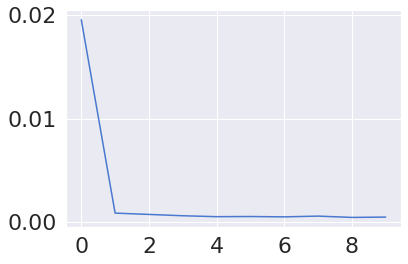

10/10 [==============================] - 0s 3ms/step - loss: 5.9434e-16


MAE        MSE  MAPE
Train 211.99 144,450.48  3.50
Test  202.69 105,399.92  2.31

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

Stationarity_adf  Stationarity_kpss  Normality  \
Test Statistics                          -6.72               0.25       0.81   
p-value                                   0.00               0.10       0.00   
Used Lag                                  6.00              16.00        NaN   
Used Observations                       293.00                NaN        NaN   
Critical Value(1%)                       -3.45                NaN        NaN   
Maximum Information Criteria          4,074.84                NaN        NaN   
Critical Value(10%)                        NaN               0.35        NaN   
Alternative                                NaN                NaN        NaN   

                              Autocorr(lag1)  Autocorr(lag5)  Autocorr(lag10)  \
Test Statistics                         2.71           12.00            18.71   
p-value                                 0.10            0.03             0.04   
Used Lag                                 NaN             NaN              NaN   
Used Observations                        NaN             NaN              NaN   
Critical Value(1%)                       NaN             NaN              NaN   
Maximum Information Criteria             NaN             NaN              NaN   
Critical Value(10%)                      NaN             NaN              NaN   
Alternative                              NaN             NaN              NaN   

                              Autocorr(lag50) Heteroscedasticity  
Test Statistics                         53.80               0.43  
p-value                                  0.33               0.00  
Used Lag                                  NaN                NaN  
Used Observations                         NaN                NaN  
Critical Value(1%)                        NaN                NaN  
Maximum Information Criteria              NaN                NaN  
Critical Value(10%)                       NaN                NaN  
Alternative                               NaN          two-sided

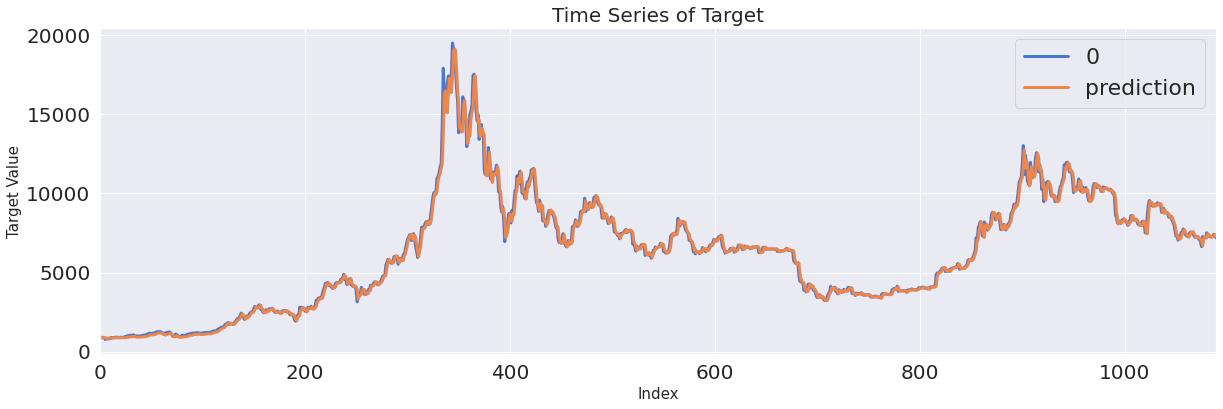

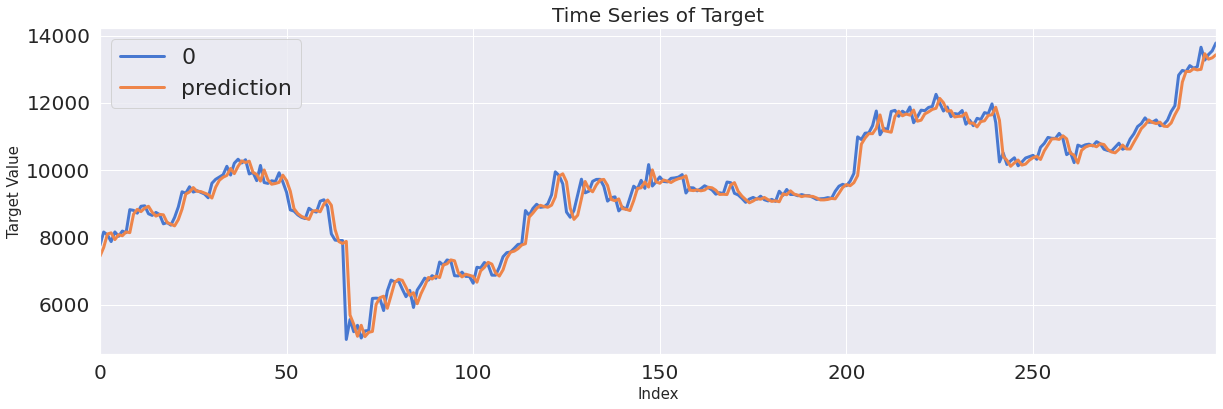

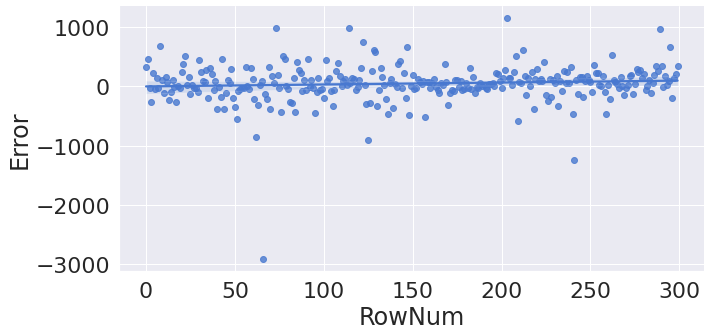

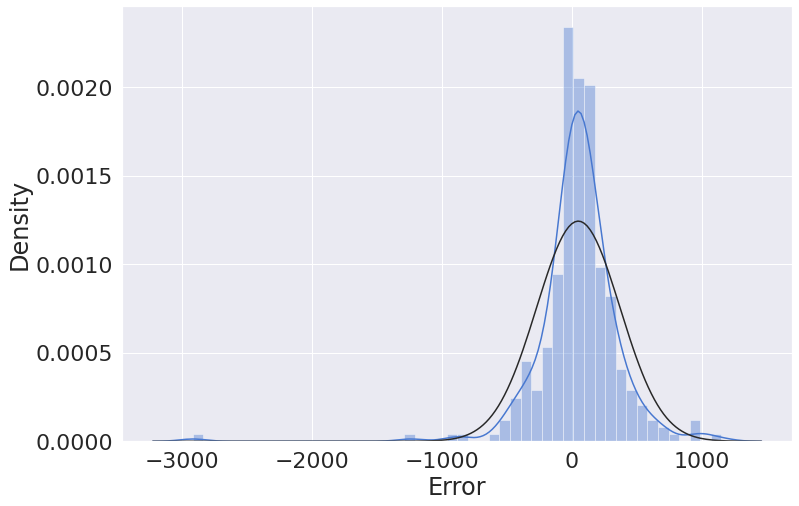

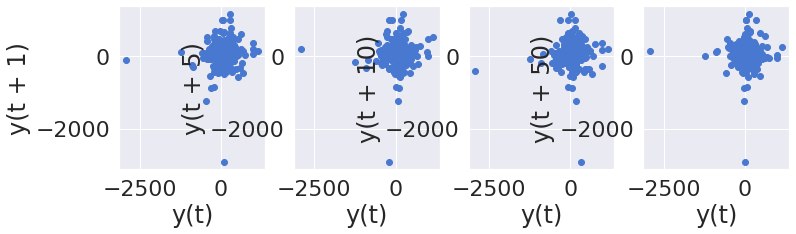

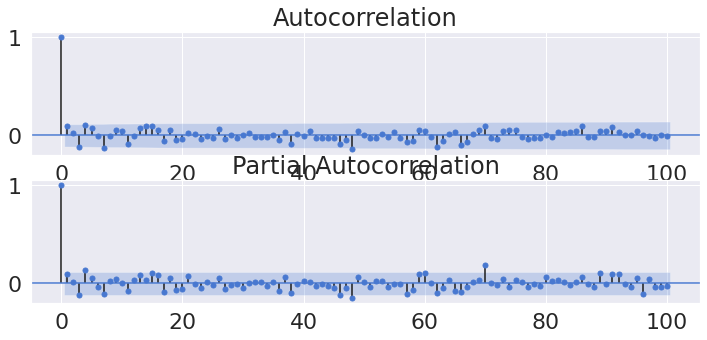

In [18]:
# Data Loading
location = './Bitcoin.csv'
raw_all = pd.read_csv(location, index_col='Date')
raw_all.index = pd.to_datetime(raw_all.index)

# Parameters
criteria = '2020-01-01'
scaler = preprocessing.MinMaxScaler()
sequence = 5
batch_size = 32
epoch = 10
verbose = 1
dropout_ratio = 0

# Feature Engineering
## Train & Test Split
train = raw_all.loc[raw_all.index < criteria,:]
test = raw_all.loc[raw_all.index >= criteria,:]
print('Train_size:', train.shape, 'Test_size:', test.shape)

## Scaling
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## X / Y Split
# 여기서 time window를 설정하는 부분으로
# 예를들어 
# 이경우 A ~ I  까지 총 9 개의 Train date가 있으며
# sequnce가 5인 경우로 I 라는 총 DATA를 예측할 때 X_train 갯수는 len(train_scaled) - sequnce = 9 - 5 = 4로 총 개의 time winodow가 나오게 된다.

# 2020,1,1      A , B ,C ,D, E               F
# 2021.1,2      B , C, D, E, F               G
# 2021.1.3      C, D, E, ,F, G,              H
# 2021.1.4      D ,E ,F,  G  H               I

# 이런식으로 각 날짜별로 윈도우를 설정하기 위한 코드이다.

    

X_train, Y_train = [], []
for index in range(len(train_scaled) - sequence):
    X_train.append(train_scaled[index: index + sequence])
    Y_train.append(train_scaled[index + sequence])
X_test, Y_test = [], []
for index in range(len(test_scaled) - sequence):
    X_test.append(test_scaled[index: index + sequence])
    Y_test.append(test_scaled[index + sequence])


# 위에서 X_train / y_train의 값은 list로 나오므로 여기서 np.array를 통해서 numpy array로 변환한다.
## Retype and Reshape
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_test, Y_test = np.array(X_test), np.array(Y_test)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)
### 위에서 그냥 np.array를 한것인데 아래처럼 변환됨
# ######### 여기서 중요한게 MLP 에서 값이 들어가는 순서가 중요한데
## 들어가는 순서는 시계열 이나 , 비시계열 딥러닝에서도 동일함
########  X_train =   (row수 ,  sequnce의 길이 ,  feature의 수(=column의 수) )  - 3차원
#######   Y_train = (row수 , column 수)   -  2차원

# MLP
###### 위에서의 형태는 3차원 (1090, 5, 1)  = X_train =   (row수 ,  sequnce의 길이 ,  feature의 수(=column의 수) )
###### 아래에서 3차원의 데이터 형태를 2차원으로 변경한다.  X_train: (1090, 5) Y_train: (1090, 1)
###### 2차원으로 변경할 때 (row수 , feature의 갯수(=columns수) ) 로 변경함 

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])
print('Reshaping for MLP')
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)


# model 하나씩 쌓는 Sequntial 로 만듦
model = Sequential()
# h1 -> 128개의뉴런으로 입력이 어떻게 되어있는지를 알려주어야함;. 
#         (1090,5,1) --> 여기서 row의 1090은 넣어줄 필요가 없음 어차피 miniBatch가 되면서 다 들어가게 되므로, 그래서 5개의 feature가 들어간다는 것이 중요함  ##########
#                        그래서 X_train.shape[1]의 shape이 들어가게 된다.

#                       총 1090,5,1 --> 5,1090으로 눕혀서 생각해보면 mini batch 사이즈 만큼 1090개에서 띄어져서 들어가게 되고 '
#                                      첫번째 128개 layer를 들어가서 나오면  (5,1090) --> (128,1090) 으로 변한다. 이말은 5개 feature를 가지고 128개의 hidden feature로 변환했다는 의미이다.



# 여기서는 2차원 이므로 위에서 3 ->2차원으로 줄여서 input_shape=(X_train.shape[1],)    이렇게 쓴거고
#          만약에 위에서 3->2차원으로 안줄이면      input_shape=(X_train.shape[1],X_train.shape[2]) 이렇게 맨처음에 row 수 빼고는 다 넣어주어야 함
## 이렇게 할 경우 (None,5,128)로 나오는 데 이것은 X_train의 (1090,5)에서 피처 5개의 시간축은 동일하게 유지한 상태로 1개의 column에 대해서만 128개로 늘리는 결과를 가져옴
## 이렇게 할 경우 -->> Faltten이 필요함

# model.add(Dense(128, input_shape=(X_train.shape[1],X_train.shape[2]), activation='relu'))

model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))

# 128개의 ratio가 0.2 = > 128*0.2 이므로 랜덤하게 줄임
model.add(Dropout(dropout_ratio))    

# 256개 layer 추가
model.add(Dense(256, activation='relu'))

model.add(Dropout(dropout_ratio)) 
model.add(Dense(128, activation='relu')) 
model.add(Dropout(dropout_ratio)) 
model.add(Dense(64, activation='relu'))
model.add(Dropout(dropout_ratio)) 


# 위에서 배열을 2차원으로 넣을 경우 y의 결과값을 맞춰주기 위해서 Flatten을 사용해야함
# model.add(Flatten())

# 마지막에 Dense (1) 이라는 것은 최종적으로 (1,1090) 으로 나오게 한다는 것이다.
# y_train 값이 결국에는 1개이기 때문에 1개로 바꿔준다.
model.add(Dense(1))


model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
model_fit = model.fit(X_train, Y_train, 
                      batch_size=batch_size, epochs=epoch,
                      verbose=verbose)

plt.plot(pd.DataFrame(model_fit.history))
plt.grid(True)
plt.show()

# prediction
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

# evaluation
result = model.evaluate(X_test, Y_test_pred)
if scaler != []:
  # 위에서 scaler을 했기 때문에 다시 scaling 되어있는 것을 복원을 해줘야함
    Y_train = scaler.inverse_transform(Y_train)
    Y_train_pred = scaler.inverse_transform(Y_train_pred)
    Y_test = scaler.inverse_transform(Y_test)
    Y_test_pred = scaler.inverse_transform(Y_test_pred)
Score_MLP, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), 
                                                      pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=True)
display(Score_MLP)

#error analysis
error_analysis(Residual_te, ['Error'], pd.DataFrame(X_test), graph_on=True)

### RNN

Train_size: (1095, 1) Test_size: (305, 1)
X_train: (1035, 60, 1) Y_train: (1035, 1)
X_test: (245, 60, 1) Y_test: (245, 1)
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 60, 128)           16640     
                                                                 
 dropout_20 (Dropout)        (None, 60, 128)           0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 60, 256)           98560     
                                                                 
 dropout_21 (Dropout)        (None, 60, 256)           0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 60, 128)           49280     
                                                                 
 dropout_22 (Dropout)        (None, 60, 128)           0        

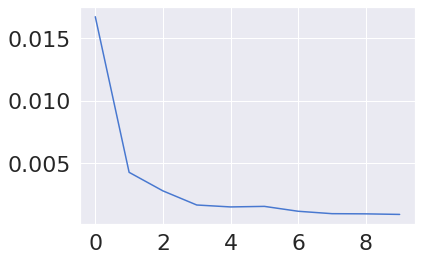

8/8 [==============================] - 1s 36ms/step - loss: 4.0095e-15


MAE        MSE  MAPE
Train 326.61 266,834.09  5.10
Test  329.75 232,483.74  3.88

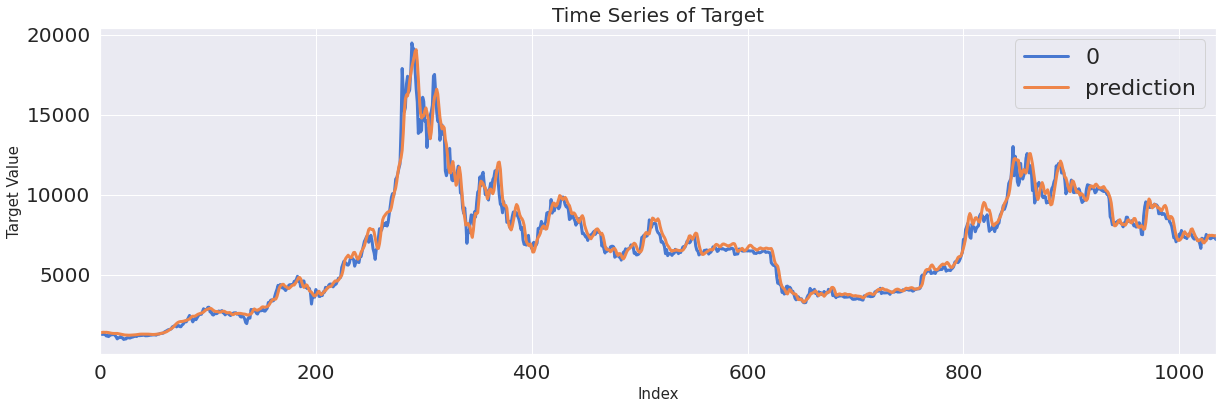

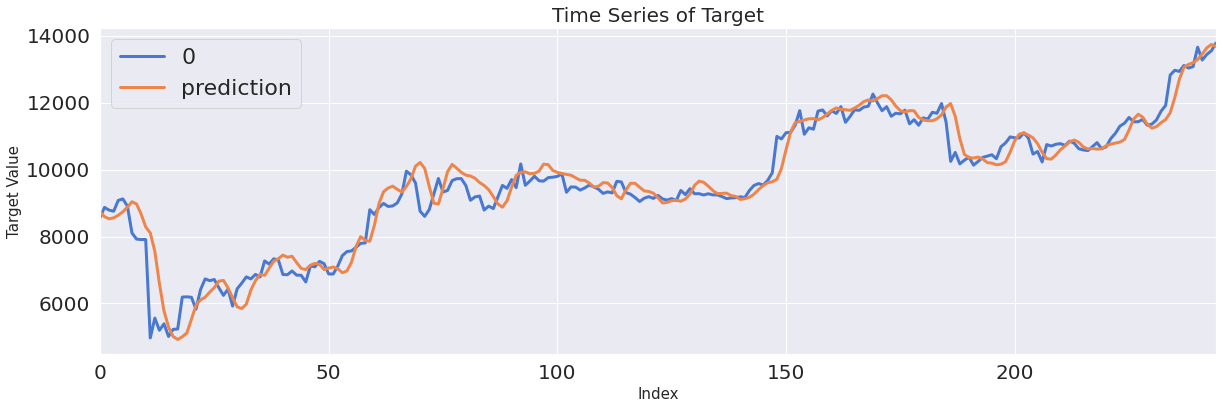

In [19]:
# Data Loading
location = './Bitcoin.csv'
raw_all = pd.read_csv(location, index_col='Date')
raw_all.index = pd.to_datetime(raw_all.index)

# Parameters
criteria = '2020-01-01'
scaler = preprocessing.MinMaxScaler()
sequence = 60
batch_size = 32
epoch = 10
verbose = 1
dropout_ratio = 0

# Feature Engineering
## Train & Test Split
train = raw_all.loc[raw_all.index < criteria,:]
test = raw_all.loc[raw_all.index >= criteria,:]
print('Train_size:', train.shape, 'Test_size:', test.shape)

## Scaling
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## X / Y Split
X_train, Y_train = [], []
for index in range(len(train_scaled) - sequence):
    X_train.append(train_scaled[index: index + sequence])
    Y_train.append(train_scaled[index + sequence])
X_test, Y_test = [], []
for index in range(len(test_scaled) - sequence):
    X_test.append(test_scaled[index: index + sequence])
    Y_test.append(test_scaled[index + sequence])

## Retype and Reshape
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_test, Y_test = np.array(X_test), np.array(Y_test)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# RNN
# MLP에서는 3차원 --> 2차원을 변경함 , 그 이유는 더 LOSS의 감소율이 좋았기 때문에
# 그러나 RNN에서는 시간의 정보가 들어가야 하므로 3차원 그대로 넣어주어야 함
# 아래의 Input_shape에서는 
########  X_train =   (row수 ,  sequnce의 길이 ,  feature의 수(=column의 수) )  - 3차원
### 여기서 sequnce의 길이와 , feature의 수가 들어감 

model = Sequential()

# 여기서 return_sequnces는 출력된 값을 다시 받아올 것인지에 대한 것 (=True) 로 해주어야함
model.add(SimpleRNN(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
model.add(Dropout(dropout_ratio)) 
model.add(SimpleRNN(256, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(SimpleRNN(128, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(SimpleRNN(64, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# 아래의 summary 에서 input (None,60,1) -> output (None,60,128) 의 설명이 MLP 에서는 1개의 Feature가 128개의 feauture로 바뀐다고 해석했음
# 그러나 RNN에서는 들어갔던 1의 정보가 다음에도 영향을 미치는 식으로 변경이 되므로
##### RNN에서의 해석은 60개의 SEQUNCE의 정보가 128개의 SEQUNCE 패턴의 정보로 변환이 되었다고 해석을 해야 맞음

model.summary()
model_fit = model.fit(X_train, Y_train, 
                      batch_size=batch_size, epochs=epoch,
                      verbose=verbose)

plt.plot(pd.DataFrame(model_fit.history))
plt.grid(True)
plt.show()

# prediction
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

# evaluation
result = model.evaluate(X_test, Y_test_pred)
if scaler != []:
    Y_train = scaler.inverse_transform(Y_train)
    Y_train_pred = scaler.inverse_transform(Y_train_pred)
    Y_test = scaler.inverse_transform(Y_test)
    Y_test_pred = scaler.inverse_transform(Y_test_pred)
Score_RNN, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), 
                                                      pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=True)
display(Score_RNN)

# error analysis
# error_analysis(Residual_te, ['Error'], pd.DataFrame(X_train.reshape(X_train.shape[0], X_train.shape[1])), graph_on=True)

### LSTM

Train_size: (1095, 1) Test_size: (305, 1)
X_train: (1035, 60, 1) Y_train: (1035, 1)
X_test: (245, 60, 1) Y_test: (245, 1)
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 128)           66560     
                                                                 
 dropout_24 (Dropout)        (None, 60, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 256)           394240    
                                                                 
 dropout_25 (Dropout)        (None, 60, 256)           0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 128)           197120    
                                                                 
 dropout_26 (Dropout)        (None, 60, 128)           0        

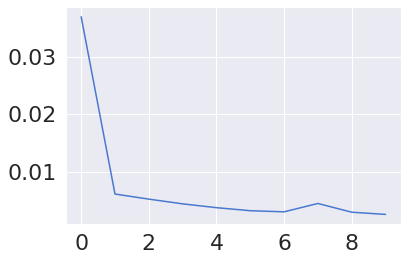

8/8 [==============================] - 4s 187ms/step - loss: 5.4741e-16


MAE        MSE  MAPE
Train 559.35 788,905.69  8.52
Test  590.77 687,434.95  6.58

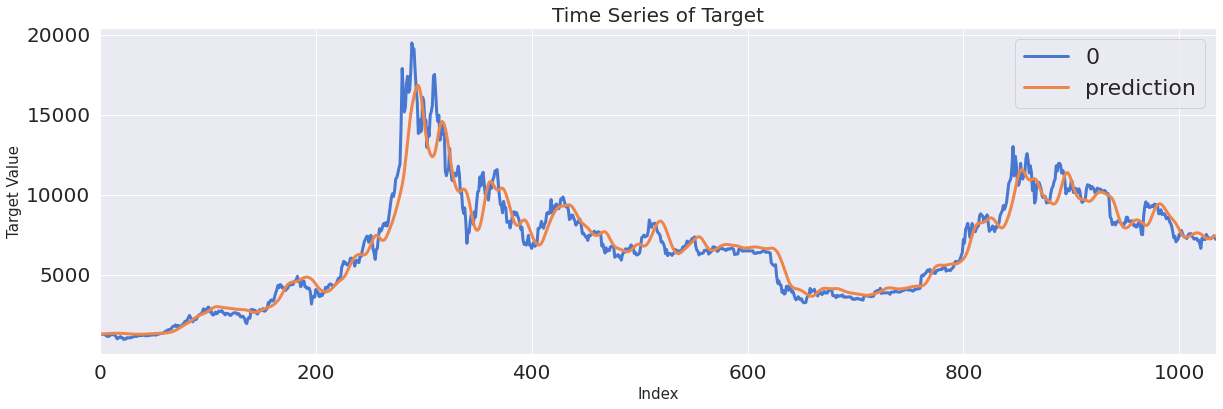

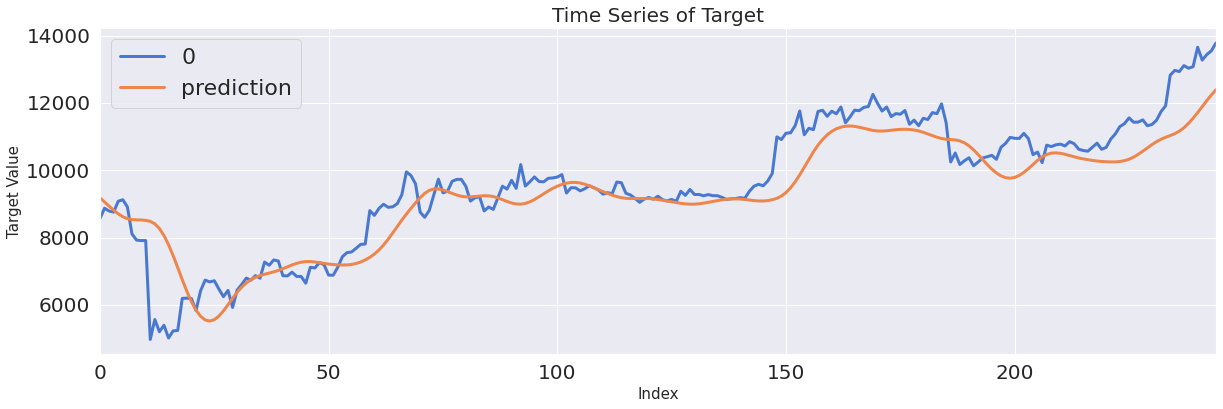

In [20]:
# Data Loading
location = './Bitcoin.csv'
raw_all = pd.read_csv(location, index_col='Date')
raw_all.index = pd.to_datetime(raw_all.index)

# Parameters
criteria = '2020-01-01'
scaler = preprocessing.MinMaxScaler()
sequence = 60
batch_size = 32
epoch = 10
verbose = 1
dropout_ratio = 0

# Feature Engineering
## Train & Test Split
train = raw_all.loc[raw_all.index < criteria,:]
test = raw_all.loc[raw_all.index >= criteria,:]
print('Train_size:', train.shape, 'Test_size:', test.shape)

## Scaling
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## X / Y Split
X_train, Y_train = [], []
for index in range(len(train_scaled) - sequence):
    X_train.append(train_scaled[index: index + sequence])
    Y_train.append(train_scaled[index + sequence])
X_test, Y_test = [], []
for index in range(len(test_scaled) - sequence):
    X_test.append(test_scaled[index: index + sequence])
    Y_test.append(test_scaled[index + sequence])

## Retype and Reshape
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_test, Y_test = np.array(X_test), np.array(Y_test)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# LSTM
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
model.add(Dropout(dropout_ratio)) 
model.add(LSTM(256, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(LSTM(128, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 

# 여기서 마지막 LSTM layer에서 return_sequnces 값을 False로 하면 전 시퀀스 값을 반영하지 않아서 시간차원이 없으지므로
# Flatten의 효과와 같이 차원이 감소되는 효과가 있다. --> 출력자체를 sequncial 하지 않게함

model.add(LSTM(64, return_sequences=False, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
model_fit = model.fit(X_train, Y_train, 
                      batch_size=batch_size, epochs=epoch,
                      verbose=verbose)

plt.plot(pd.DataFrame(model_fit.history))
plt.grid(True)
plt.show()

# prediction
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

# evaluation
result = model.evaluate(X_test, Y_test_pred)
if scaler != []:
    Y_train = scaler.inverse_transform(Y_train)
    Y_train_pred = scaler.inverse_transform(Y_train_pred)
    Y_test = scaler.inverse_transform(Y_test)
    Y_test_pred = scaler.inverse_transform(Y_test_pred)
Score_LSTM, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), 
                                                      pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=True)
display(Score_LSTM)

# error analysis
# error_analysis(Residual_te, ['Error'], pd.DataFrame(X_train.reshape(X_train.shape[0], X_train.shape[1])), graph_on=True)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

Stationarity_adf  Stationarity_kpss  Normality  \
Test Statistics                          -6.14               0.09       0.85   
p-value                                   0.00               0.10       0.00   
Used Lag                                 11.00              16.00        NaN   
Used Observations                       233.00                NaN        NaN   
Critical Value(1%)                       -3.46                NaN        NaN   
Maximum Information Criteria          3,203.53                NaN        NaN   
Critical Value(10%)                        NaN               0.35        NaN   
Alternative                                NaN                NaN        NaN   

                              Autocorr(lag1)  Autocorr(lag5)  Autocorr(lag10)  \
Test Statistics                        80.96          105.91           118.92   
p-value                                 0.00            0.00             0.00   
Used Lag                                 NaN             NaN              NaN   
Used Observations                        NaN             NaN              NaN   
Critical Value(1%)                       NaN             NaN              NaN   
Maximum Information Criteria             NaN             NaN              NaN   
Critical Value(10%)                      NaN             NaN              NaN   
Alternative                              NaN             NaN              NaN   

                              Autocorr(lag50) Heteroscedasticity  
Test Statistics                        184.40               0.28  
p-value                                  0.00               0.00  
Used Lag                                  NaN                NaN  
Used Observations                         NaN                NaN  
Critical Value(1%)                        NaN                NaN  
Maximum Information Criteria              NaN                NaN  
Critical Value(10%)                       NaN                NaN  
Alternative                               NaN          two-sided

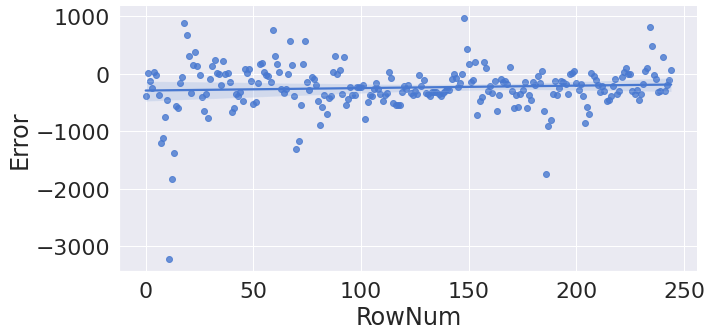

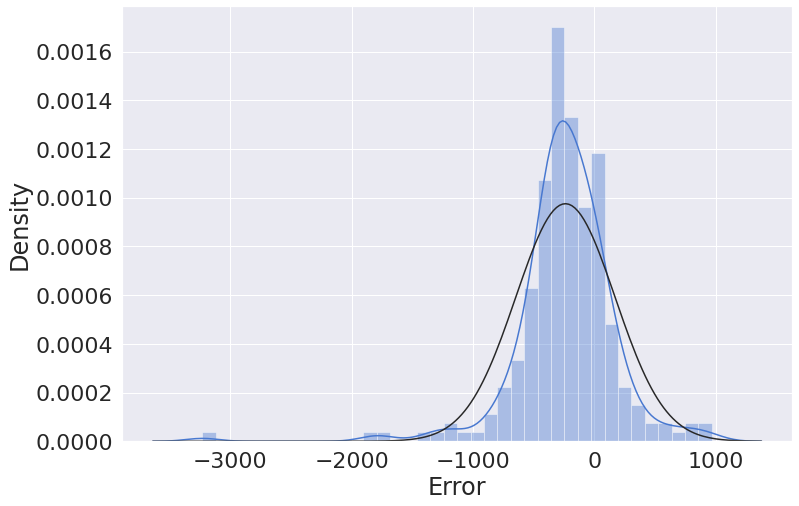

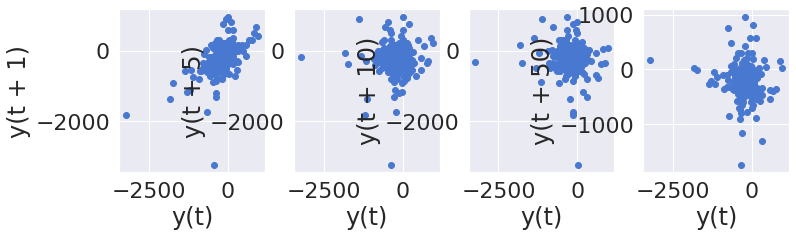

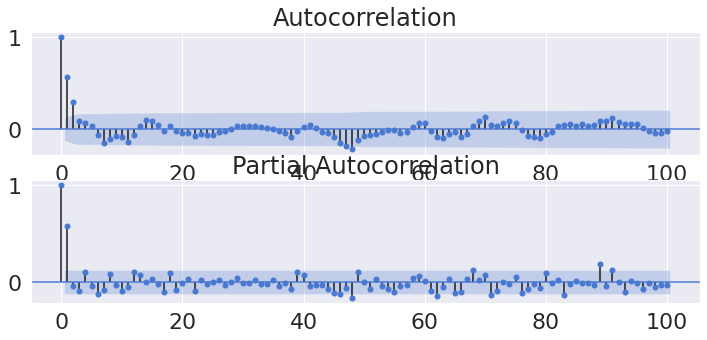

In [22]:
error_analysis(Residual_te, ['Error'], pd.DataFrame(X_train.reshape(X_train.shape[0], X_train.shape[1])), graph_on=True)

### GRU

Train_size: (1095, 1) Test_size: (305, 1)
X_train: (1035, 60, 1) Y_train: (1035, 1)
X_test: (245, 60, 1) Y_test: (245, 1)
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 60, 128)           50304     
                                                                 
 dropout_28 (Dropout)        (None, 60, 128)           0         
                                                                 
 gru_1 (GRU)                 (None, 60, 256)           296448    
                                                                 
 dropout_29 (Dropout)        (None, 60, 256)           0         
                                                                 
 gru_2 (GRU)                 (None, 60, 128)           148224    
                                                                 
 dropout_30 (Dropout)        (None, 60, 128)           0        

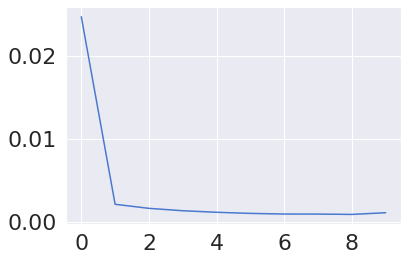

8/8 [==============================] - 1s 101ms/step - loss: 6.7067e-16


MAE        MSE  MAPE
Train 347.15 270,618.77  5.36
Test  333.79 224,626.83  3.89

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

Stationarity_adf  Stationarity_kpss  Normality  \
Test Statistics                          -6.14               0.09       0.85   
p-value                                   0.00               0.10       0.00   
Used Lag                                 11.00              16.00        NaN   
Used Observations                       233.00                NaN        NaN   
Critical Value(1%)                       -3.46                NaN        NaN   
Maximum Information Criteria          3,203.53                NaN        NaN   
Critical Value(10%)                        NaN               0.35        NaN   
Alternative                                NaN                NaN        NaN   

                              Autocorr(lag1)  Autocorr(lag5)  Autocorr(lag10)  \
Test Statistics                        80.96          105.91           118.92   
p-value                                 0.00            0.00             0.00   
Used Lag                                 NaN             NaN              NaN   
Used Observations                        NaN             NaN              NaN   
Critical Value(1%)                       NaN             NaN              NaN   
Maximum Information Criteria             NaN             NaN              NaN   
Critical Value(10%)                      NaN             NaN              NaN   
Alternative                              NaN             NaN              NaN   

                              Autocorr(lag50) Heteroscedasticity  
Test Statistics                        184.40               0.28  
p-value                                  0.00               0.00  
Used Lag                                  NaN                NaN  
Used Observations                         NaN                NaN  
Critical Value(1%)                        NaN                NaN  
Maximum Information Criteria              NaN                NaN  
Critical Value(10%)                       NaN                NaN  
Alternative                               NaN          two-sided

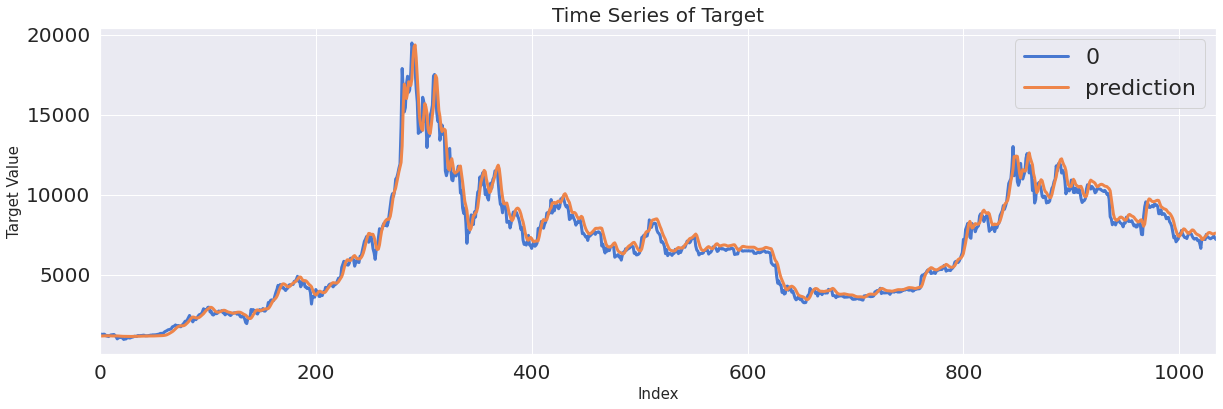

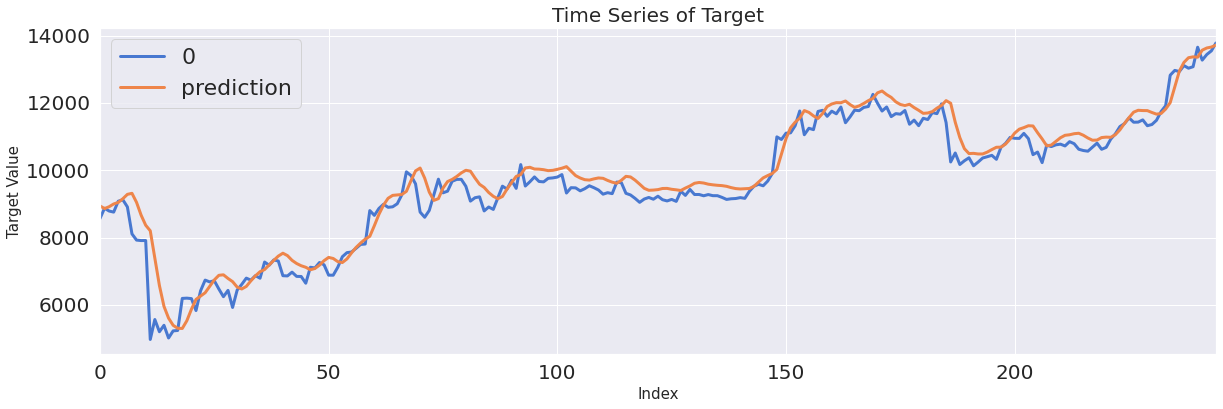

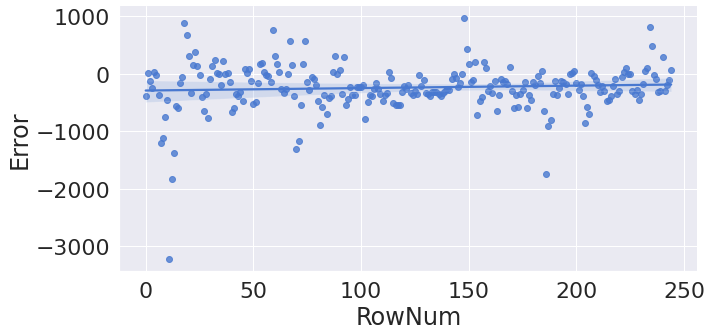

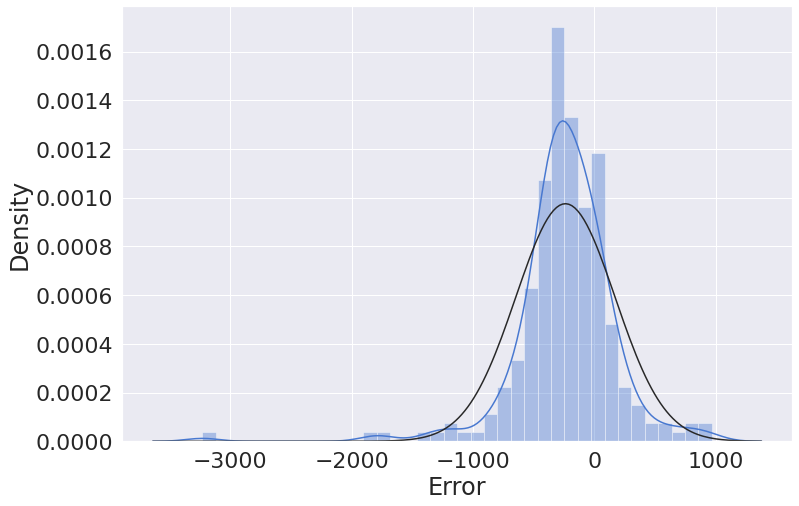

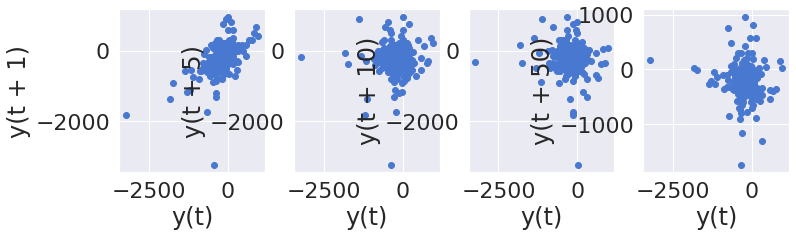

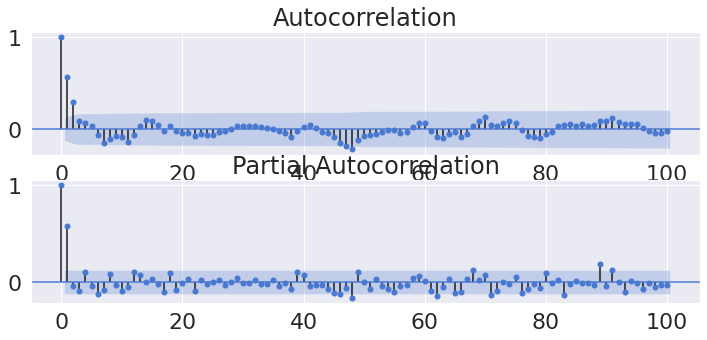

In [21]:
# Data Loading
location = './Bitcoin.csv'
raw_all = pd.read_csv(location, index_col='Date')
raw_all.index = pd.to_datetime(raw_all.index)

# Parameters
criteria = '2020-01-01'
scaler = preprocessing.MinMaxScaler()
sequence = 60
batch_size = 32
epoch = 10
verbose = 1
dropout_ratio = 0

# Feature Engineering
## Train & Test Split
train = raw_all.loc[raw_all.index < criteria,:]
test = raw_all.loc[raw_all.index >= criteria,:]
print('Train_size:', train.shape, 'Test_size:', test.shape)

## Scaling
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## X / Y Split
X_train, Y_train = [], []
for index in range(len(train_scaled) - sequence):
    X_train.append(train_scaled[index: index + sequence])
    Y_train.append(train_scaled[index + sequence])
X_test, Y_test = [], []
for index in range(len(test_scaled) - sequence):
    X_test.append(test_scaled[index: index + sequence])
    Y_test.append(test_scaled[index + sequence])

## Retype and Reshape
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_test, Y_test = np.array(X_test), np.array(Y_test)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# GRU
model = Sequential()
model.add(GRU(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
model.add(Dropout(dropout_ratio)) 
model.add(GRU(256, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(GRU(128, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 

# 여기도 마찬가지고 return_sequnces를 False로 하면 전 sequnce 반영하지 않으므로 시간축을 배제하게 함
# 차원의 수를 감소하는 효과가 있음 --> Flatten 대체
model.add(GRU(64, return_sequences=False, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
model_fit = model.fit(X_train, Y_train, 
                      batch_size=batch_size, epochs=epoch,
                      verbose=verbose)

plt.plot(pd.DataFrame(model_fit.history))
plt.grid(True)
plt.show()

# prediction
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

# evaluation
result = model.evaluate(X_test, Y_test_pred)
if scaler != []:
    Y_train = scaler.inverse_transform(Y_train)
    Y_train_pred = scaler.inverse_transform(Y_train_pred)
    Y_test = scaler.inverse_transform(Y_test)
    Y_test_pred = scaler.inverse_transform(Y_test_pred)
Score_GRU, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), 
                                                      pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=True)
display(Score_GRU)

# error analysis
error_analysis(Residual_te, ['Error'], pd.DataFrame(X_train.reshape(X_train.shape[0], X_train.shape[1])), graph_on=True)

## Example 2: Bike Sharing Prediction

### MLP

Train_size: (13128, 29) Test_size: (4416, 29)
X_train: (13128, 24) Y_train: (13128, 1)
X_test: (4416, 24) Y_test: (4416, 1)
X_train: (13128, 24) Y_train: (13128, 1)
X_test: (4416, 24) Y_test: (4416, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               3200      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                    

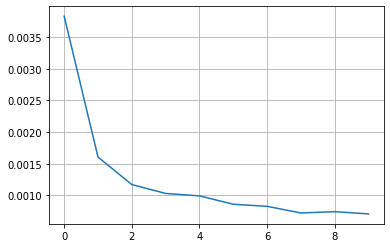

138/138 [==============================] - 0s 2ms/step - loss: 2.0768e-16


MAE       MSE  MAPE
Train 15.61    629.88 36.00
Test  85.32 18,563.00 44.62

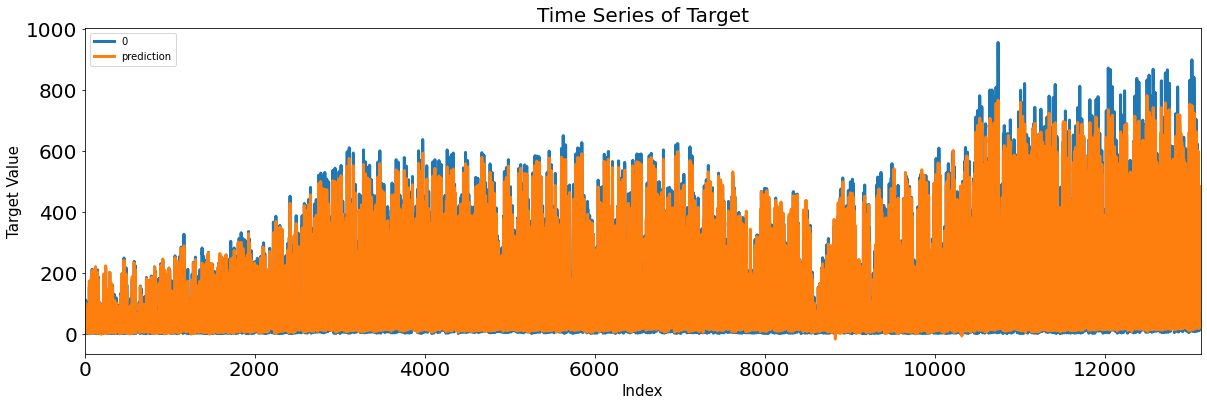

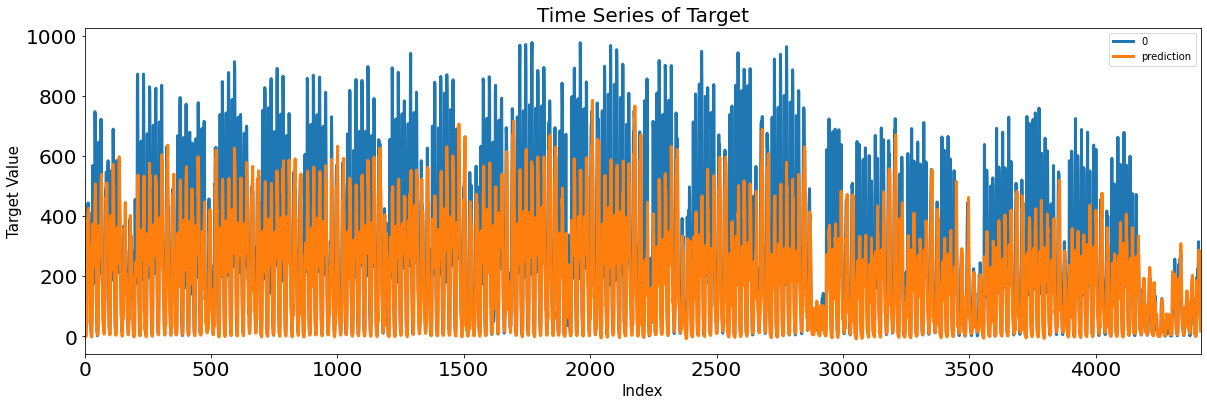

In [5]:
# Data Loading
location = './Bike_Sharing_Demand_Full.csv'
raw_all = pd.read_csv(location)

# Feature Engineering
raw_fe = feature_engineering(raw_all)
### Reality ###
target = ['count_trend', 'count_seasonal', 'count_Day', 'count_Week', 'count_diff']
raw_feR = feature_engineering_year_duplicated(raw_fe, target)
###############

# Data Split
# Confirm of input and output
Y_colname = ['count']
X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
X_colname = [x for x in raw_fe.columns if x not in Y_colname+X_remove]
X_train_feR, X_test_feR, Y_train_feR, Y_test_feR = datasplit_ts(raw_feR, Y_colname, X_colname, '2012-07-01')
### Reality ###
target = ['count_lag1', 'count_lag2']
X_test_feR = feature_engineering_lag_modified(Y_test_feR, X_test_feR, target)
###############

# Parameters
scaler_X_tr = preprocessing.MinMaxScaler()
scaler_Y_tr = preprocessing.MinMaxScaler()
# sequence = 60
batch_size = 32
epoch = 10
verbose = 1
dropout_ratio = 0

# Feature Engineering
## Scaling
X_train = scaler_X_tr.fit_transform(X_train_feR)
Y_train = scaler_Y_tr.fit_transform(Y_train_feR)
X_test = scaler_X_tr.transform(X_test_feR)
Y_test = scaler_Y_tr.transform(Y_test_feR)

## Retype and Reshape
# X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
# X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# MLP는 시간에 대한 것을 반영하지 않으므로 2차원으로 넣어주면됨 (시간차원에 대해 반영하려면 3차원)
# 그러므로 Reshape 과정이 필요없이 바로 2차원으로 입력해줌

print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# MLP
model = Sequential()
model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dropout(dropout_ratio)) 
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout_ratio)) 
model.add(Dense(128, activation='relu'))
model.add(Dropout(dropout_ratio)) 
model.add(Dense(64, activation='relu'))
model.add(Dropout(dropout_ratio)) 
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
model_fit = model.fit(X_train, Y_train, 
                      batch_size=batch_size, epochs=epoch,
                      verbose=verbose)

plt.plot(pd.DataFrame(model_fit.history))
plt.grid(True)
plt.show()

# prediction
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

# evaluation
result = model.evaluate(X_test, Y_test_pred)
if scaler_Y_tr != []:
    Y_train = scaler_Y_tr.inverse_transform(Y_train)
    Y_train_pred = scaler_Y_tr.inverse_transform(Y_train_pred)
    Y_test = scaler_Y_tr.inverse_transform(Y_test)
    Y_test_pred = scaler_Y_tr.inverse_transform(Y_test_pred)
Score_MLP, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), 
                                                      pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=True)
display(Score_MLP)

# error analysis
# error_analysis(Residual_te, ['Error'], pd.DataFrame(X_train.reshape(X_train.shape[0], X_train.shape[1])), graph_on=True)

### RNN

#### sequence = 1

Train_size: (13128, 29) Test_size: (4416, 29)
X_train: (13128, 24) Y_train: (13128, 1)
X_test: (4416, 24) Y_test: (4416, 1)
X_train: (13128, 1, 24) Y_train: (13128, 1)
X_test: (4416, 1, 24) Y_test: (4416, 1)
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_4 (SimpleRNN)     (None, 1, 128)            19584     
_________________________________________________________________
dropout_20 (Dropout)         (None, 1, 128)            0         
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 1, 256)            98560     
_________________________________________________________________
dropout_21 (Dropout)         (None, 1, 256)            0         
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 1, 128)            49280     
____________________________________________

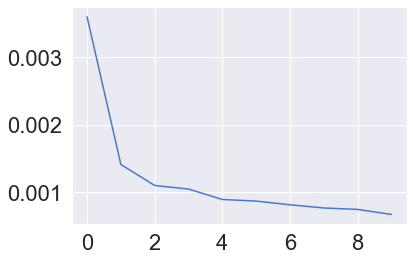

138/138 [==============================] - 0s 665us/step - loss: 3.4105e-16


MAE       MSE   MAPE
Train 18.15    709.54  44.51
Test  87.36 14,031.05 100.39

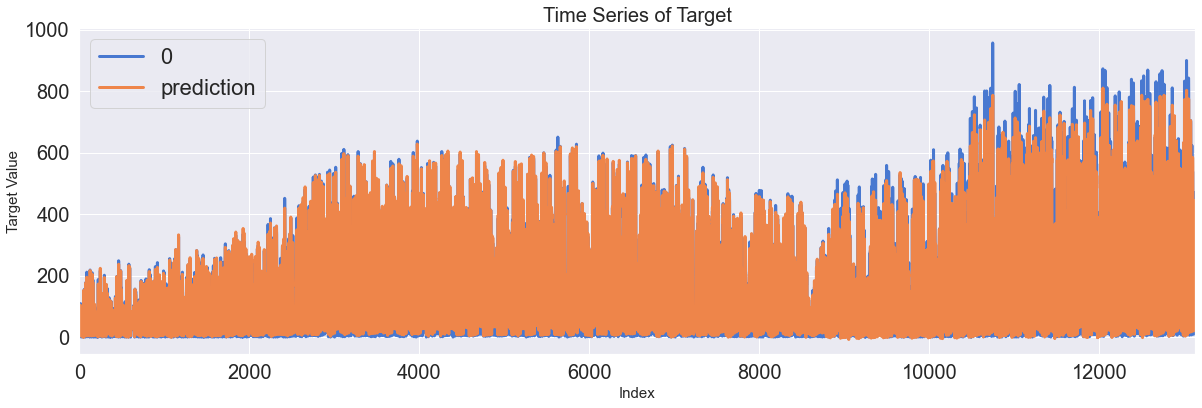

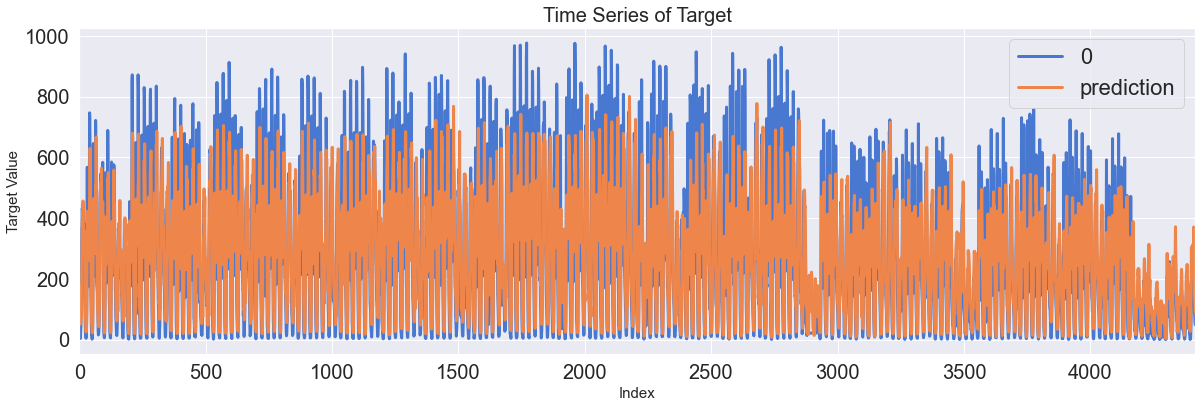

In [ ]:
# Data Loading
location = './Bike_Sharing_Demand_Full.csv'
raw_all = pd.read_csv(location)

# Feature Engineering
raw_fe = feature_engineering(raw_all)
### Reality ###
target = ['count_trend', 'count_seasonal', 'count_Day', 'count_Week', 'count_diff']
raw_feR = feature_engineering_year_duplicated(raw_fe, target)
###############

# Data Split
# Confirm of input and output
Y_colname = ['count']
X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
X_colname = [x for x in raw_fe.columns if x not in Y_colname+X_remove]
X_train_feR, X_test_feR, Y_train_feR, Y_test_feR = datasplit_ts(raw_feR, Y_colname, X_colname, '2012-07-01')
### Reality ###
target = ['count_lag1', 'count_lag2']
X_test_feR = feature_engineering_lag_modified(Y_test_feR, X_test_feR, target)
###############

# Parameters
scaler_X_tr = preprocessing.MinMaxScaler()
scaler_Y_tr = preprocessing.MinMaxScaler()


# feature가 이미 24개가 있으므로 sequnce를 어떻게 나누는 것이 좋은 지 확인함
# sequence = 24
batch_size = 32
epoch = 10
verbose = 1
dropout_ratio = 0

# Feature Engineering
## Scaling
X_train = scaler_X_tr.fit_transform(X_train_feR)
Y_train = scaler_Y_tr.fit_transform(Y_train_feR)
X_test = scaler_X_tr.transform(X_test_feR)
Y_test = scaler_Y_tr.transform(Y_test_feR)

## Retype and Reshape
######## 기존에 2차원인 데이터를 --> 3차원으로 변경해주어야함
####### 앞에서는 (rows의 수 (=data의 수), sequnce수(=시간길이) , feuature의 수(=columns의 수)) --> 이것과 동일하게 해줌  
###### 여기서 의미하는 것은 Y: E / T:1 / X : A,B,C,D  T라는 1시점에서 X : A,B,C,D가 동일하게 Y:E라는 결과를 가졌다는 의미를 말함

X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# RNN
model = Sequential()

# 여기서 Input_shape에서는 데이터의 총갯수 row 수는 어차피 mini-batch를 통해서 들어가므로 상관없으므로 shape[1], shape[2]의 정보만 들어감
# 24개의 feature가 --> 128개의 feature로 변환 된다는 의미임
model.add(SimpleRNN(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
model.add(Dropout(dropout_ratio)) 
model.add(SimpleRNN(256, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(SimpleRNN(128, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(SimpleRNN(64, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
model_fit = model.fit(X_train, Y_train, 
                      batch_size=batch_size, epochs=epoch,
                      verbose=verbose)

plt.plot(pd.DataFrame(model_fit.history))
plt.grid(True)
plt.show()

# prediction
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

# evaluation
result = model.evaluate(X_test, Y_test_pred)
if scaler_Y_tr != []:
    Y_train = scaler_Y_tr.inverse_transform(Y_train)
    Y_train_pred = scaler_Y_tr.inverse_transform(Y_train_pred)
    Y_test = scaler_Y_tr.inverse_transform(Y_test)
    Y_test_pred = scaler_Y_tr.inverse_transform(Y_test_pred)
Score_RNN, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), 
                                                      pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=True)
display(Score_RNN)

# error analysis
# error_analysis(Residual_te, ['Error'], pd.DataFrame(X_train.reshape(X_train.shape[0], X_train.shape[2])), graph_on=True)

#### sequence = 24

Train_size: (13128, 29) Test_size: (4416, 29)
X_train: (13128, 24) Y_train: (13128, 1)
X_test: (4416, 24) Y_test: (4416, 1)
window && reshape 후 X_train: (13104, 24, 24) Y_train: (13104, 1)
window && reshape 후 X_test: (4392, 24, 24) Y_test: (4392, 1)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 24, 128)           19584     
                                                                 
 dropout_4 (Dropout)         (None, 24, 128)           0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 24, 256)           98560     
                                                                 
 dropout_5 (Dropout)         (None, 24, 256)           0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 24, 128)           49280     
  

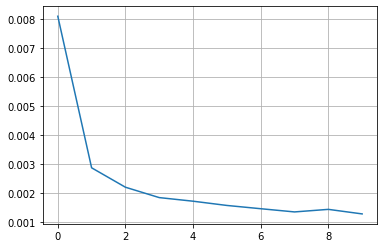

138/138 [==============================] - 2s 14ms/step - loss: 5.9232e-16


MAE      MSE  MAPE
Train 22.64 1,019.74 61.27
Test  52.00 5,260.09 73.77

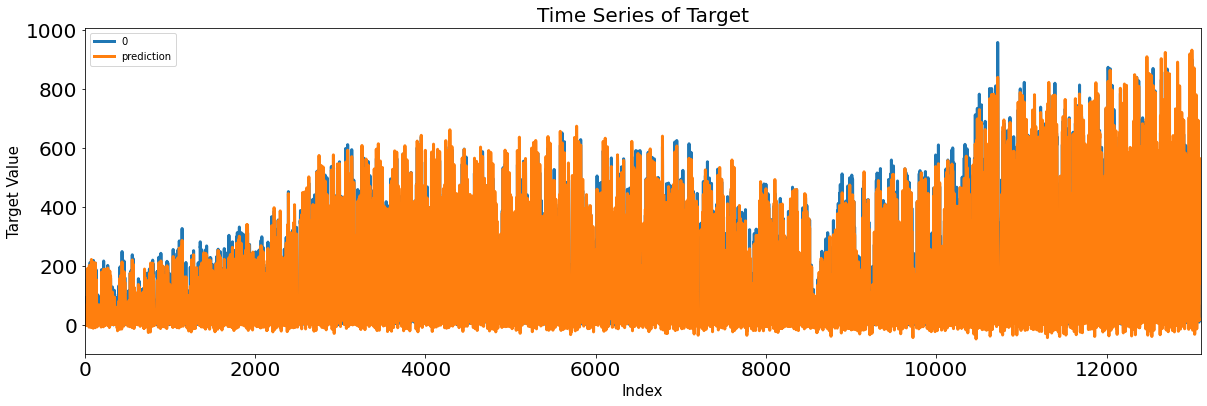

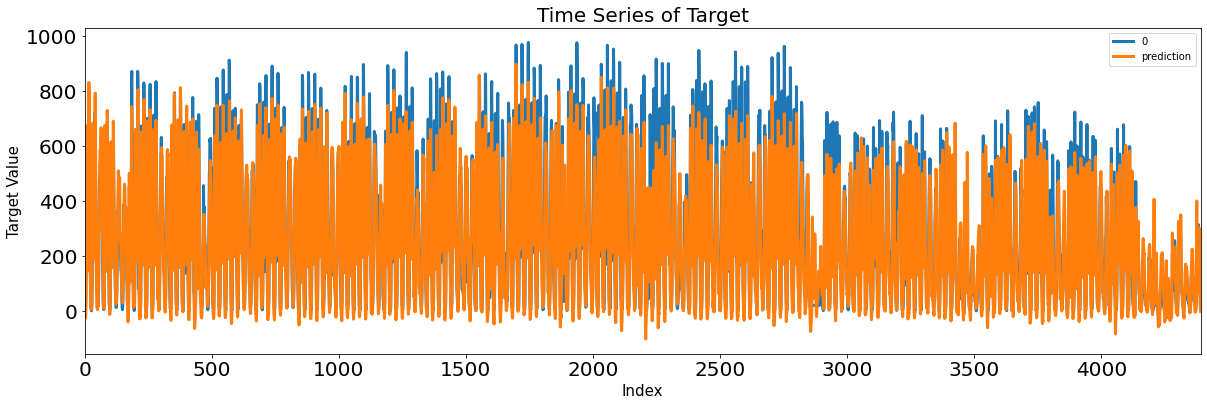

In [6]:
# Data Loading
location = './Bike_Sharing_Demand_Full.csv'
raw_all = pd.read_csv(location)

# Feature Engineering
raw_fe = feature_engineering(raw_all)
### Reality ###
target = ['count_trend', 'count_seasonal', 'count_Day', 'count_Week', 'count_diff']
raw_feR = feature_engineering_year_duplicated(raw_fe, target)
###############

# Data Split
# Confirm of input and output
Y_colname = ['count']
X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
X_colname = [x for x in raw_fe.columns if x not in Y_colname+X_remove]
X_train_feR, X_test_feR, Y_train_feR, Y_test_feR = datasplit_ts(raw_feR, Y_colname, X_colname, '2012-07-01')
### Reality ###
target = ['count_lag1', 'count_lag2']
X_test_feR = feature_engineering_lag_modified(Y_test_feR, X_test_feR, target)
###############

# Parameters
scaler_X_tr = preprocessing.MinMaxScaler()
scaler_Y_tr = preprocessing.MinMaxScaler()
# 아래의 sequnce는 아무값이나 써도 됨. 그러나 여기서는 data가 각각이 시간으로 되어있는 데이터이므로 일별 정보를 반영하기 위해서
# 24시간 즉, 1일에 해당하는 sequnce를 설정함
sequence = 24
batch_size = 32
epoch = 10
verbose = 1
dropout_ratio = 0

# Feature Engineering
## Scaling
X_train_scaled = scaler_X_tr.fit_transform(X_train_feR)
Y_train_scaled = scaler_Y_tr.fit_transform(Y_train_feR)
X_test_scaled = scaler_X_tr.transform(X_test_feR)
Y_test_scaled = scaler_Y_tr.transform(Y_test_feR)

## X / Y Split
##### 24개의 sequnce를 반영하기 위해서는 (rows수 (=전체 data의 수에서 sequnce의 수를 뺀거), sequnce 의 길이 , feature의 수 (=columns의 수))가 나오게 됨
####  X_train: (13128, 24) Y_train: (13128, 1)  --> time window 나누기전
####  X_train: (13104, 24, 24) Y_train: (13104, 1) --> time window 나누고 나서 --> row의 수는 len(X_trian)- sequence의 길이 , 가운데 24는 sequence의 길이, 마지막 24는 feature의 수 (=coulumn의 수)

X_train, Y_train = [], []
for index in range(len(X_train_scaled) - sequence):
    X_train.append(np.array(X_train_scaled[index: index + sequence]))
    Y_train.append(np.ravel(Y_train_scaled[index + sequence:index + sequence + 1]))
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_test, Y_test = [], []
for index in range(len(X_test_scaled) - sequence):
    X_test.append(np.array(X_test_scaled[index: index + sequence]))
    Y_test.append(np.ravel(Y_test_scaled[index + sequence:index + sequence + 1]))  
X_test, Y_test = np.array(X_test), np.array(Y_test) 

# Retype and Reshape
# 여기서 reshpae도 동일하게 (rows수 (=data의 수), sequnce 의 길이 , feature의 수 (=columns의 수))
# 아래 reshape은 별로 할필요는 없지만 그래도 정확하게 하기 위해서 아래로 작성함
# -1은 그냥 남는 거 마지막 1개라는 의미임,총 3차원에서 2개를 알면 마지막은 그냥 자동으로 계산될 수 있으므로 -1을 넣음
X_train = X_train.reshape(X_train.shape[0], sequence, -1)
X_test = X_test.reshape(X_test.shape[0], sequence, -1)
print("window && reshape 후",'X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print("window && reshape 후",'X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# RNN
model = Sequential()
# 24개(columns의 수) 의 feature가 128개로 바뀐다는 것을 의미함
model.add(SimpleRNN(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
model.add(Dropout(dropout_ratio)) 
model.add(SimpleRNN(256, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(SimpleRNN(128, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(SimpleRNN(64, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
model_fit = model.fit(X_train, Y_train, 
                      batch_size=batch_size, epochs=epoch,
                      verbose=verbose)

plt.plot(pd.DataFrame(model_fit.history))
plt.grid(True)
plt.show()

# prediction
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

# evaluation
result = model.evaluate(X_test, Y_test_pred)
if scaler_Y_tr != []:
    Y_train = scaler_Y_tr.inverse_transform(Y_train)
    Y_train_pred = scaler_Y_tr.inverse_transform(Y_train_pred)
    Y_test = scaler_Y_tr.inverse_transform(Y_test)
    Y_test_pred = scaler_Y_tr.inverse_transform(Y_test_pred)
Score_RNN, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), 
                                                      pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=True)
display(Score_RNN)

# error analysis
# error_analysis(Residual_te, ['Error'], X_test_feR.reset_index().iloc[:,1:].loc[Residual_te.index], graph_on=True)

### LSTM (seq=24)

In [7]:
# Data Loading
location = './Bike_Sharing_Demand_Full.csv'
raw_all = pd.read_csv(location)

# Feature Engineering
raw_fe = feature_engineering(raw_all)
### Reality ###
target = ['count_trend', 'count_seasonal', 'count_Day', 'count_Week', 'count_diff']
raw_feR = feature_engineering_year_duplicated(raw_fe, target)
###############

# Data Split
# Confirm of input and output
Y_colname = ['count']
X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
X_colname = [x for x in raw_fe.columns if x not in Y_colname+X_remove]
X_train_feR, X_test_feR, Y_train_feR, Y_test_feR = datasplit_ts(raw_feR, Y_colname, X_colname, '2012-07-01')
### Reality ###
target = ['count_lag1', 'count_lag2']
X_test_feR = feature_engineering_lag_modified(Y_test_feR, X_test_feR, target)
###############

# Parameters
scaler_X_tr = preprocessing.MinMaxScaler()
scaler_Y_tr = preprocessing.MinMaxScaler()
sequence = 24
batch_size = 32
epoch = 10
verbose = 1
dropout_ratio = 0

# Feature Engineering
## Scaling
X_train_scaled = scaler_X_tr.fit_transform(X_train_feR)
Y_train_scaled = scaler_Y_tr.fit_transform(Y_train_feR)
X_test_scaled = scaler_X_tr.transform(X_test_feR)
Y_test_scaled = scaler_Y_tr.transform(Y_test_feR)

## X / Y Split
X_train, Y_train = [], []
for index in range(len(X_train_scaled) - sequence):
    X_train.append(np.array(X_train_scaled[index: index + sequence]))
    Y_train.append(np.ravel(Y_train_scaled[index + sequence:index + sequence + 1]))
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_test, Y_test = [], []
for index in range(len(X_test_scaled) - sequence):
    X_test.append(np.array(X_test_scaled[index: index + sequence]))
    Y_test.append(np.ravel(Y_test_scaled[index + sequence:index + sequence + 1]))  
X_test, Y_test = np.array(X_test), np.array(Y_test) 

## Retype and Reshape
# 여기서도 정리를 하면 reshape은 (row의수 (=데이터의수, x_train 전체길이에서 - sequnce의 수만큼 뺌), sequnce의 길이 (=time window의 길이), feature의 수 (=columns의 수))
# 위에서 구한 것을 다시 reshape으로 안해도 되지만 코드상의 편의를 위하여 아래와 같이 맞춰 줌 
# 3차원에서 2개의 값을 알면 나머지는 한개는 그냥 계산 되므로 -1을 써서 자동으로 배열이 생성되게함
X_train = X_train.reshape(X_train.shape[0], sequence, -1)
X_test = X_test.reshape(X_test.shape[0], sequence, -1)
print("window && reshape 후",'X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print("window && reshape 후",'X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# LSTM
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
model.add(Dropout(dropout_ratio)) 
model.add(LSTM(256, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(LSTM(128, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(LSTM(64, return_sequences=False, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
model_fit = model.fit(X_train, Y_train, 
                      batch_size=batch_size, epochs=epoch,
                      verbose=verbose)

plt.plot(pd.DataFrame(model_fit.history))
plt.grid(True)
plt.show()

# prediction
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

# evaluation
result = model.evaluate(X_test, Y_test_pred)
if scaler_Y_tr != []:
    Y_train = scaler_Y_tr.inverse_transform(Y_train)
    Y_train_pred = scaler_Y_tr.inverse_transform(Y_train_pred)
    Y_test = scaler_Y_tr.inverse_transform(Y_test)
    Y_test_pred = scaler_Y_tr.inverse_transform(Y_test_pred)
Score_LSTM, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), 
                                                      pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=True)
display(Score_LSTM)

# error analysis
error_analysis(Residual_te, ['Error'], X_test_feR.reset_index().iloc[:,1:].loc[Residual_te.index], graph_on=True)

Train_size: (13128, 29) Test_size: (4416, 29)
X_train: (13128, 24) Y_train: (13128, 1)
X_test: (4416, 24) Y_test: (4416, 1)
window && reshape 후 X_train: (13104, 24, 24) Y_train: (13104, 1)
window && reshape 후 X_test: (4392, 24, 24) Y_test: (4392, 1)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 128)           78336     
                                                                 
 dropout_8 (Dropout)         (None, 24, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 24, 256)           394240    
                                                                 
 dropout_9 (Dropout)         (None, 24, 256)           0         
                                                                 
 lstm_2 (LSTM)               (None, 24, 128)           197120    
  

KeyboardInterrupt: ignored

### GRU (seq=24)

Train_size: (13128, 29) Test_size: (4416, 29)
X_train: (13128, 24) Y_train: (13128, 1)
X_test: (4416, 24) Y_test: (4416, 1)
X_train: (13104, 24, 24) Y_train: (13104, 1)
X_test: (4392, 24, 24) Y_test: (4392, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 24, 128)           59136     
                                                                 
 dropout (Dropout)           (None, 24, 128)           0         
                                                                 
 gru_1 (GRU)                 (None, 24, 256)           296448    
                                                                 
 dropout_1 (Dropout)         (None, 24, 256)           0         
                                                                 
 gru_2 (GRU)                 (None, 24, 128)           148224    
                                            

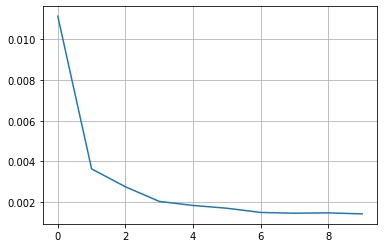

138/138 [==============================] - 7s 48ms/step - loss: 3.7100e-16


MAE      MSE  MAPE
Train 22.13 1,159.57 47.39
Test  63.96 8,508.19 54.83

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

Stationarity_adf  Stationarity_kpss  Normality  \
Test Statistics                          -7.50               0.60       0.96   
p-value                                   0.00               0.02       0.00   
Used Lag                                 31.00              31.00        NaN   
Used Observations                     4,360.00                NaN        NaN   
Critical Value(1%)                       -3.43                NaN        NaN   
Maximum Information Criteria         48,420.51                NaN        NaN   
Critical Value(10%)                        NaN               0.35        NaN   
Alternative                                NaN                NaN        NaN   

                              Autocorr(lag1)  Autocorr(lag5)  Autocorr(lag10)  \
Test Statistics                     1,212.97        1,522.17         1,690.67   
p-value                                 0.00            0.00             0.00   
Used Lag                                 NaN             NaN              NaN   
Used Observations                        NaN             NaN              NaN   
Critical Value(1%)                       NaN             NaN              NaN   
Maximum Information Criteria             NaN             NaN              NaN   
Critical Value(10%)                      NaN             NaN              NaN   
Alternative                              NaN             NaN              NaN   

                              Autocorr(lag50) Heteroscedasticity  
Test Statistics                      4,014.19               0.92  
p-value                                  0.00               0.06  
Used Lag                                  NaN                NaN  
Used Observations                         NaN                NaN  
Critical Value(1%)                        NaN                NaN  
Maximum Information Criteria              NaN                NaN  
Critical Value(10%)                       NaN                NaN  
Alternative                               NaN          two-sided

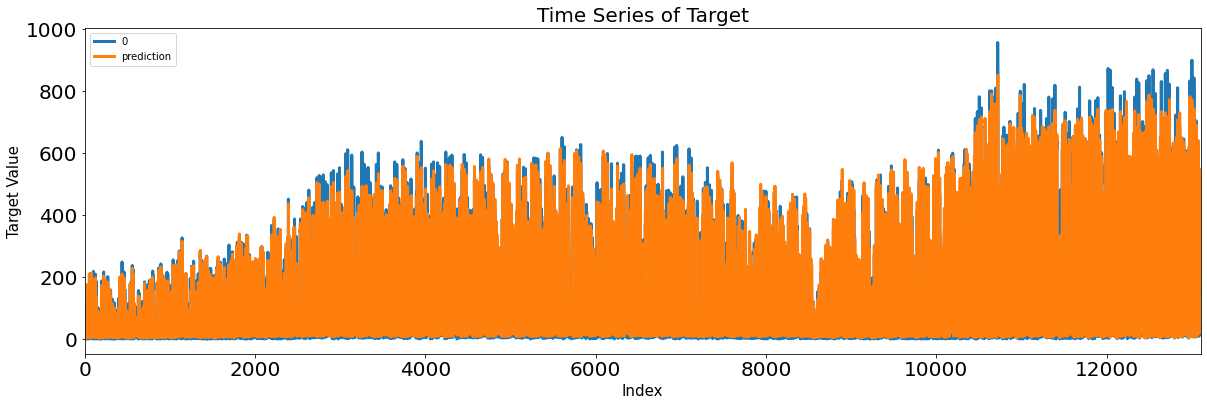

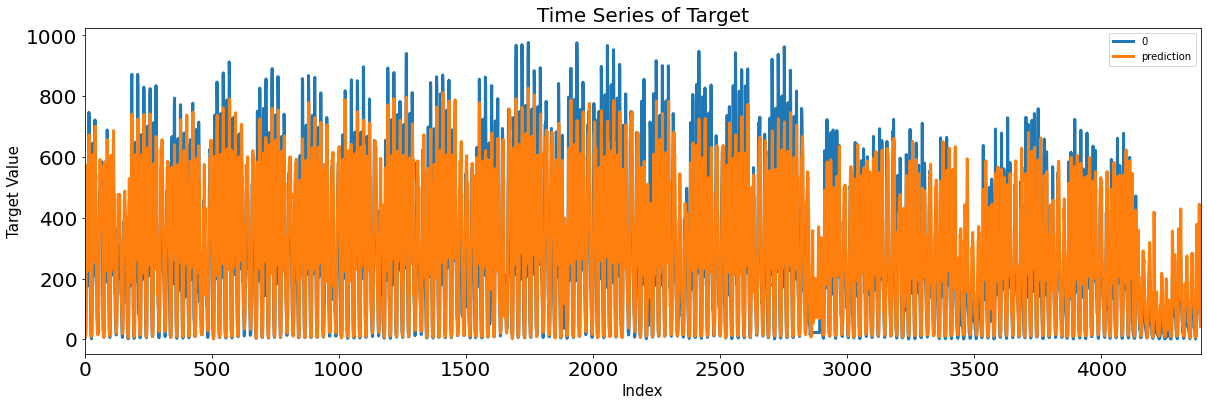

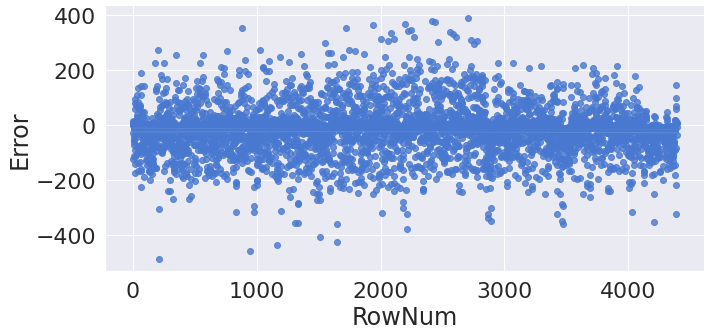

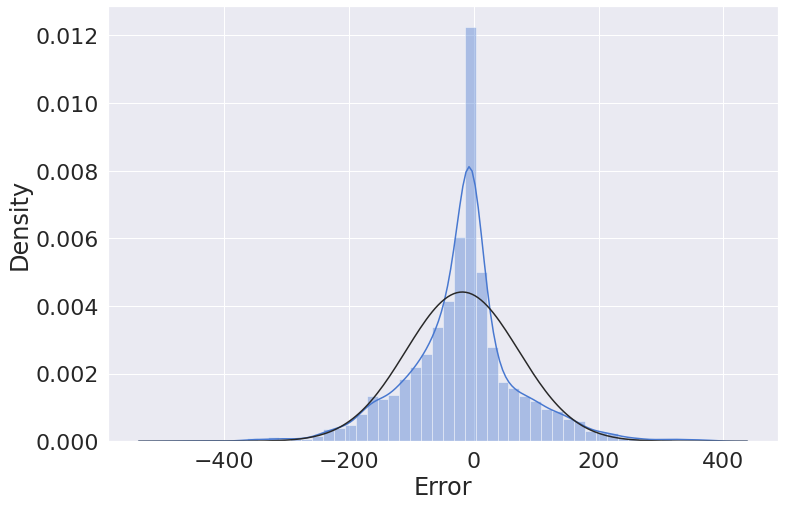

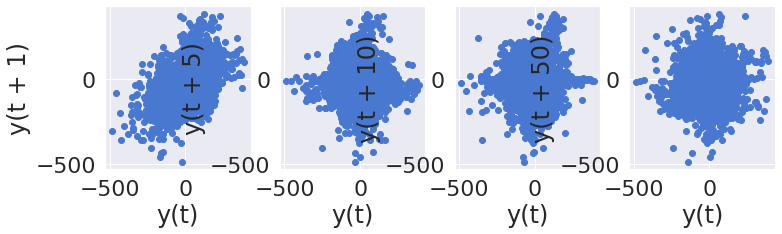

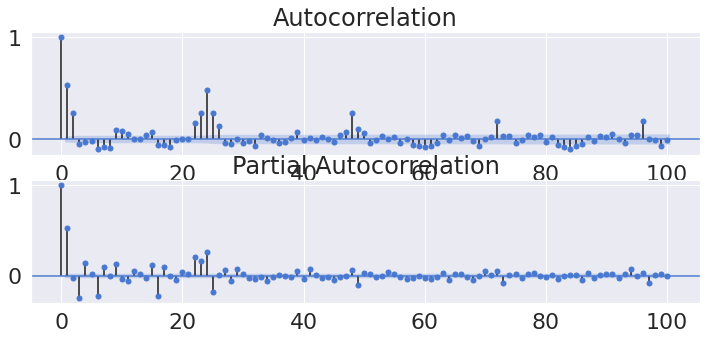

In [6]:
# Data Loading
location = './Bike_Sharing_Demand_Full.csv'
raw_all = pd.read_csv(location)

# Feature Engineering
raw_fe = feature_engineering(raw_all)
### Reality ###
target = ['count_trend', 'count_seasonal', 'count_Day', 'count_Week', 'count_diff']
raw_feR = feature_engineering_year_duplicated(raw_fe, target)
###############

# Data Split
# Confirm of input and output
Y_colname = ['count']
X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
X_colname = [x for x in raw_fe.columns if x not in Y_colname+X_remove]
X_train_feR, X_test_feR, Y_train_feR, Y_test_feR = datasplit_ts(raw_feR, Y_colname, X_colname, '2012-07-01')
### Reality ###
target = ['count_lag1', 'count_lag2']
X_test_feR = feature_engineering_lag_modified(Y_test_feR, X_test_feR, target)
###############

# Parameters
scaler_X_tr = preprocessing.MinMaxScaler()
scaler_Y_tr = preprocessing.MinMaxScaler()
sequence = 24
batch_size = 32
epoch = 10
verbose = 1
dropout_ratio = 0

# Feature Engineering
## Scaling
X_train_scaled = scaler_X_tr.fit_transform(X_train_feR)
Y_train_scaled = scaler_Y_tr.fit_transform(Y_train_feR)
X_test_scaled = scaler_X_tr.transform(X_test_feR)
Y_test_scaled = scaler_Y_tr.transform(Y_test_feR)

## X / Y Split
X_train, Y_train = [], []
for index in range(len(X_train_scaled) - sequence):
    X_train.append(np.array(X_train_scaled[index: index + sequence]))
    Y_train.append(np.ravel(Y_train_scaled[index + sequence:index + sequence + 1]))
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_test, Y_test = [], []
for index in range(len(X_test_scaled) - sequence):
    X_test.append(np.array(X_test_scaled[index: index + sequence]))
    Y_test.append(np.ravel(Y_test_scaled[index + sequence:index + sequence + 1]))  
X_test, Y_test = np.array(X_test), np.array(Y_test) 

## Retype and Reshape
X_train = X_train.reshape(X_train.shape[0], sequence, -1)
X_test = X_test.reshape(X_test.shape[0], sequence, -1)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# GRU
model = Sequential()
model.add(GRU(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
model.add(Dropout(dropout_ratio)) 
model.add(GRU(256, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(GRU(128, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(GRU(64, return_sequences=False, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
model_fit = model.fit(X_train, Y_train, 
                      batch_size=batch_size, epochs=epoch,
                      verbose=verbose)

plt.plot(pd.DataFrame(model_fit.history))
plt.grid(True)
plt.show()

# prediction
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

# evaluation
result = model.evaluate(X_test, Y_test_pred)
if scaler_Y_tr != []:
    Y_train = scaler_Y_tr.inverse_transform(Y_train)
    Y_train_pred = scaler_Y_tr.inverse_transform(Y_train_pred)
    Y_test = scaler_Y_tr.inverse_transform(Y_test)
    Y_test_pred = scaler_Y_tr.inverse_transform(Y_test_pred)
Score_GRU, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), 
                                                      pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=True)
display(Score_GRU)

# error analysis
error_analysis(Residual_te, ['Error'], X_test_feR.reset_index().iloc[:,1:].loc[Residual_te.index], graph_on=True)

## Example 3: Real Estate Prediction

### MLP

Train_size: (4760, 18) Test_size: (1632, 18)
X_train: (4760, 15) Y_train: (4760, 1)
X_test: (1632, 15) Y_test: (1632, 1)
X_train: (4760, 15) Y_train: (4760, 1)
X_test: (1632, 15) Y_test: (1632, 1)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 128)               2048      
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                       

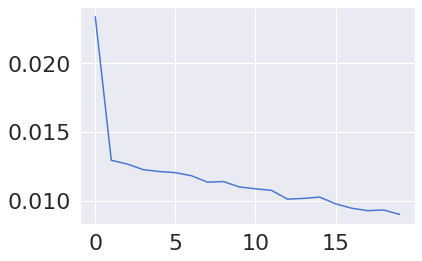

51/51 [==============================] - 0s 4ms/step - loss: 1.8242e-15


MAE   MSE  MAPE
Train 3.20 20.28  3.51
Test  7.29 65.28  7.35

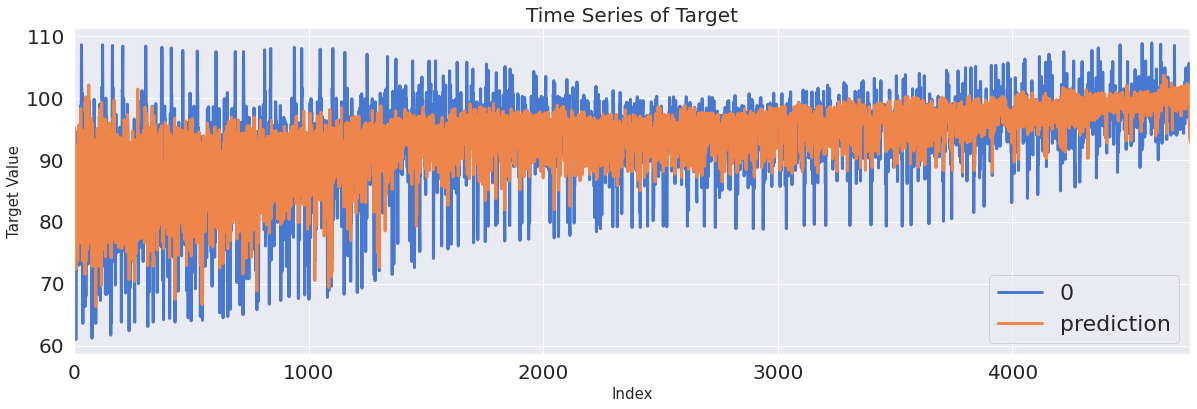

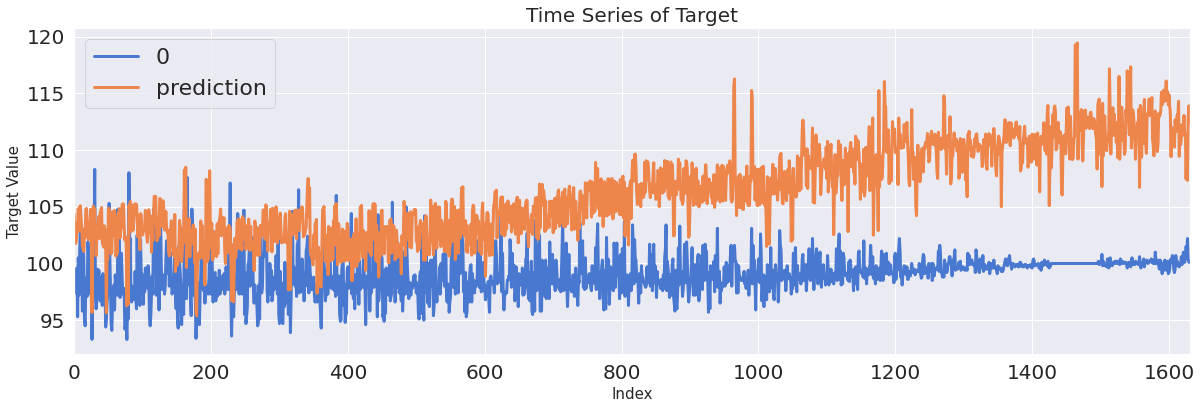

In [7]:
# Data Loading
location = './Economy.csv'
raw_all = pd.read_csv(location)
raw_all

# Feature Engineering
raw_all['Date'] = pd.to_datetime(raw_all['Date'])
raw_all.index = raw_all['Date']
raw_all = raw_all[raw_all.index >= '2010-01-01']
raw_all = raw_all[raw_all.index <= '2017-12-31']
raw_all.fillna(method='bfill', inplace=True)

# Data Split
Y_colname = ['Price']
X_remove = ['Date', 'Price_Sido']
X_colname = [x for x in raw_all.columns if x not in Y_colname+X_remove]
X_train, X_test, Y_train, Y_test = datasplit_ts(raw_all, Y_colname, X_colname, '2016-01-01')

# Parameters
# MLP 이므로 시간정보가 필요없어서 sequnce가없음
scaler_X_tr = preprocessing.MinMaxScaler()
scaler_Y_tr = preprocessing.MinMaxScaler()
# sequence = 34
batch_size = 32
epoch = 20
verbose = 1
dropout_ratio = 0

# Feature Engineering
## Scaling
# test에 대한 minMax 정보가 없으므로 임의로 train에 대한 scaler를 test에 적용함. 그래서 fit_trainsform이 아닌 trasform임
X_train = scaler_X_tr.fit_transform(X_train)
Y_train = scaler_Y_tr.fit_transform(Y_train)
X_test = scaler_X_tr.transform(X_test)
Y_test = scaler_Y_tr.transform(Y_test)

## Retype and Reshape
# X_train = X_train.reshape(X_train.shape[0], sequence, -1)
# X_test = X_test.reshape(X_test.shape[0], sequence, -1)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# MLP
model = Sequential()
model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dropout(dropout_ratio)) 
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(dropout_ratio)) 
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(dropout_ratio)) 
model.add(Dense(64, activation='relu'))
model.add(Dropout(dropout_ratio)) 
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
model_fit = model.fit(X_train, Y_train, 
                      batch_size=batch_size, epochs=epoch,
                      verbose=verbose)

plt.plot(pd.DataFrame(model_fit.history))
plt.grid(True)
plt.show()

# prediction
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

# evaluation
# 아래 scaling 했던 것을 다시 inverse scaling를 해서 결과를 사용함
result = model.evaluate(X_test, Y_test_pred)
if scaler_Y_tr != []:
    Y_train = scaler_Y_tr.inverse_transform(Y_train)
    Y_train_pred = scaler_Y_tr.inverse_transform(Y_train_pred)
    Y_test = scaler_Y_tr.inverse_transform(Y_test)
    Y_test_pred = scaler_Y_tr.inverse_transform(Y_test_pred)
Score_MLP, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), 
                                                      pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=True)
display(Score_MLP)

# error analysis
# error_analysis(Residual_te, ['Error'], X_test_feR.reset_index().iloc[:,1:].loc[Residual_te.index], graph_on=True)

### RNN

Train_size: (4760, 18) Test_size: (1632, 18)
X_train: (4760, 15) Y_train: (4760, 1)
X_test: (1632, 15) Y_test: (1632, 1)
X_train: (4726, 34, 15) Y_train: (4726, 1)
X_test: (1598, 34, 15) Y_test: (1598, 1)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 34, 128)           18432     
                                                                 
 dropout_6 (Dropout)         (None, 34, 128)           0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 34, 64)            12352     
                                                                 
 dropout_7 (Dropout)         (None, 34, 64)            0         
                                                                 
 flatten (Flatten)           (None, 2176)              0         
                                               

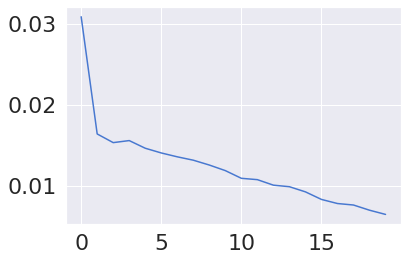

50/50 [==============================] - 1s 8ms/step - loss: 7.7969e-15


MAE   MSE  MAPE
Train 2.86 13.38  3.17
Test  7.60 75.45  7.67

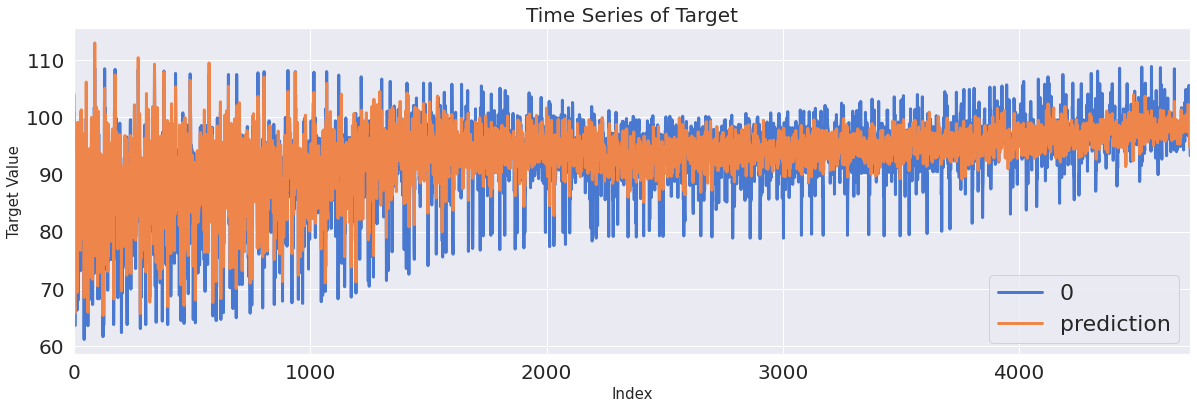

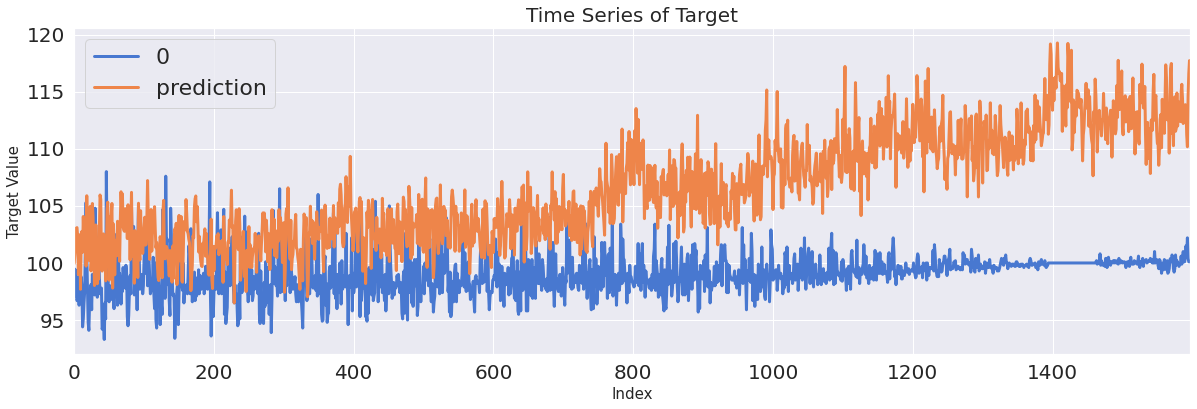

In [8]:
# Data Loading
location = './/Economy.csv'
raw_all = pd.read_csv(location)
raw_all

# Feature Engineering
raw_all['Date'] = pd.to_datetime(raw_all['Date'])
raw_all.index = raw_all['Date']
raw_all = raw_all[raw_all.index >= '2010-01-01']
raw_all = raw_all[raw_all.index <= '2017-12-31']
raw_all.fillna(method='bfill', inplace=True)

# Data Split
Y_colname = ['Price']
X_remove = ['Date', 'Price_Sido']
X_colname = [x for x in raw_all.columns if x not in Y_colname+X_remove]
X_train, X_test, Y_train, Y_test = datasplit_ts(raw_all, Y_colname, X_colname, '2016-01-01')

# Parameters
scaler_X_tr = preprocessing.MinMaxScaler()
scaler_Y_tr = preprocessing.MinMaxScaler()
sequence = 34
batch_size = 32
epoch = 20
verbose = 1
dropout_ratio = 0

# Feature Engineering
## Scaling
X_train_scaled = scaler_X_tr.fit_transform(X_train)
Y_train_scaled = scaler_Y_tr.fit_transform(Y_train)
X_test_scaled = scaler_X_tr.transform(X_test)
Y_test_scaled = scaler_Y_tr.transform(Y_test)

## X / Y Split
X_train, Y_train = [], []
for index in range(len(X_train_scaled) - sequence):
    X_train.append(np.array(X_train_scaled[index: index + sequence]))
    Y_train.append(np.ravel(Y_train_scaled[index + sequence:index + sequence + 1]))
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_test, Y_test = [], []
for index in range(len(X_test_scaled) - sequence):
    X_test.append(np.array(X_test_scaled[index: index + sequence]))
    Y_test.append(np.ravel(Y_test_scaled[index + sequence:index + sequence + 1]))  
X_test, Y_test = np.array(X_test), np.array(Y_test) 

## Retype and Reshape
X_train = X_train.reshape(X_train.shape[0], sequence, -1)
X_test = X_test.reshape(X_test.shape[0], sequence, -1)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# RNN
model = Sequential()
model.add(SimpleRNN(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
model.add(Dropout(dropout_ratio)) 
# model.add(SimpleRNN(256, return_sequences=True, activation="relu"))
# model.add(Dropout(dropout_ratio)) 
# model.add(SimpleRNN(128, return_sequences=True, activation="relu"))
# model.add(Dropout(dropout_ratio)) 
model.add(SimpleRNN(64, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
model_fit = model.fit(X_train, Y_train, 
                      batch_size=batch_size, epochs=epoch,
                      verbose=verbose)

plt.plot(pd.DataFrame(model_fit.history))
plt.grid(True)
plt.show()

# prediction
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

# evaluation
result = model.evaluate(X_test, Y_test_pred)
if scaler_Y_tr != []:
    Y_train = scaler_Y_tr.inverse_transform(Y_train)
    Y_train_pred = scaler_Y_tr.inverse_transform(Y_train_pred)
    Y_test = scaler_Y_tr.inverse_transform(Y_test)
    Y_test_pred = scaler_Y_tr.inverse_transform(Y_test_pred)
Score_RNN, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), 
                                                      pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=True)
display(Score_RNN)

# error analysis
# error_analysis(Residual_te, ['Error'], X_test_feR.reset_index().iloc[:,1:].loc[Residual_te.index], graph_on=True)

### LSTM

Train_size: (4760, 18) Test_size: (1632, 18)
X_train: (4760, 15) Y_train: (4760, 1)
X_test: (1632, 15) Y_test: (1632, 1)
X_train: (4726, 34, 15) Y_train: (4726, 1)
X_test: (1598, 34, 15) Y_test: (1598, 1)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 34, 128)           73728     
                                                                 
 dropout_8 (Dropout)         (None, 34, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                               

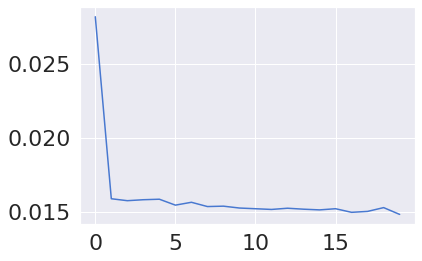

50/50 [==============================] - 2s 24ms/step - loss: 1.0494e-15


MAE   MSE  MAPE
Train 4.23 33.33  4.72
Test  1.91  4.91  1.93

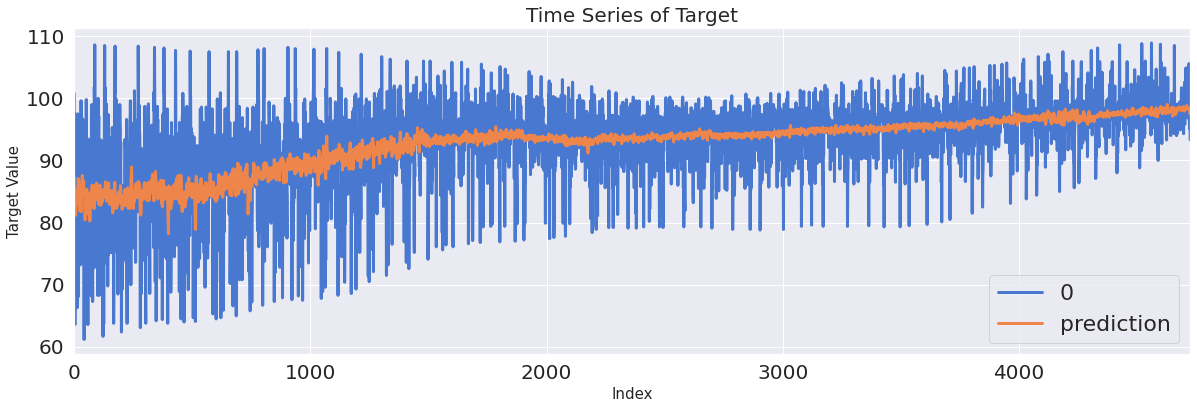

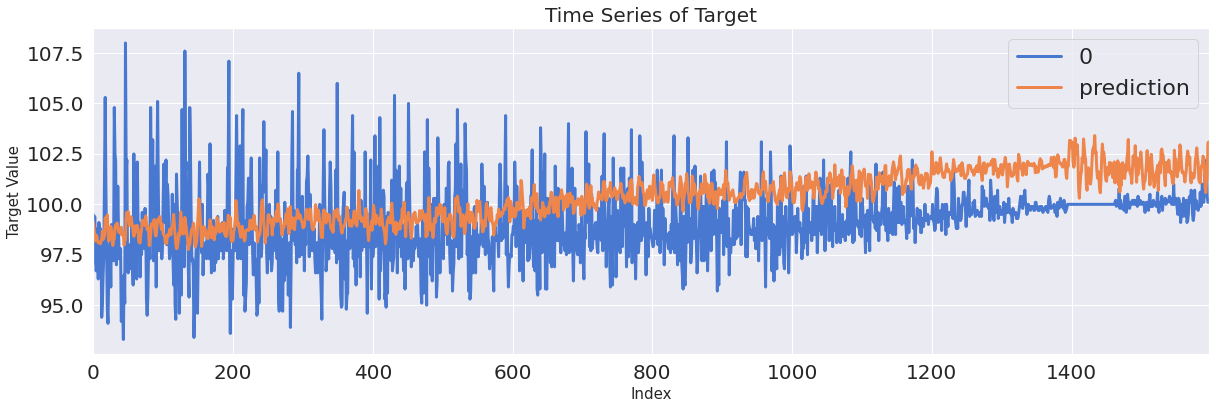

In [9]:
# Data Loading
location = './Economy.csv'
raw_all = pd.read_csv(location)
raw_all

# Feature Engineering
raw_all['Date'] = pd.to_datetime(raw_all['Date'])
raw_all.index = raw_all['Date']
raw_all = raw_all[raw_all.index >= '2010-01-01']
raw_all = raw_all[raw_all.index <= '2017-12-31']
raw_all.fillna(method='bfill', inplace=True)

# Data Split
Y_colname = ['Price']
X_remove = ['Date', 'Price_Sido']
X_colname = [x for x in raw_all.columns if x not in Y_colname+X_remove]
X_train, X_test, Y_train, Y_test = datasplit_ts(raw_all, Y_colname, X_colname, '2016-01-01')

# Parameters
scaler_X_tr = preprocessing.MinMaxScaler()
scaler_Y_tr = preprocessing.MinMaxScaler()
sequence = 34
batch_size = 32
epoch = 20
verbose = 1
dropout_ratio = 0

# Feature Engineering
## Scaling
X_train_scaled = scaler_X_tr.fit_transform(X_train)
Y_train_scaled = scaler_Y_tr.fit_transform(Y_train)
X_test_scaled = scaler_X_tr.transform(X_test)
Y_test_scaled = scaler_Y_tr.transform(Y_test)

## X / Y Split
X_train, Y_train = [], []
for index in range(len(X_train_scaled) - sequence):
    X_train.append(np.array(X_train_scaled[index: index + sequence]))
    Y_train.append(np.ravel(Y_train_scaled[index + sequence:index + sequence + 1]))
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_test, Y_test = [], []
for index in range(len(X_test_scaled) - sequence):
    X_test.append(np.array(X_test_scaled[index: index + sequence]))
    Y_test.append(np.ravel(Y_test_scaled[index + sequence:index + sequence + 1]))  
X_test, Y_test = np.array(X_test), np.array(Y_test) 

## Retype and Reshape
X_train = X_train.reshape(X_train.shape[0], sequence, -1)
X_test = X_test.reshape(X_test.shape[0], sequence, -1)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# LSTM
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
model.add(Dropout(dropout_ratio)) 
# model.add(LSTM(256, return_sequences=True, activation="relu"))
# model.add(Dropout(dropout_ratio)) 
# model.add(LSTM(128, return_sequences=True, activation="relu"))
# model.add(Dropout(dropout_ratio)) 
model.add(LSTM(64, return_sequences=False, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
model_fit = model.fit(X_train, Y_train, 
                      batch_size=batch_size, epochs=epoch,
                      verbose=verbose)

plt.plot(pd.DataFrame(model_fit.history))
plt.grid(True)
plt.show()

# prediction
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

# evaluation
result = model.evaluate(X_test, Y_test_pred)
if scaler_Y_tr != []:
    Y_train = scaler_Y_tr.inverse_transform(Y_train)
    Y_train_pred = scaler_Y_tr.inverse_transform(Y_train_pred)
    Y_test = scaler_Y_tr.inverse_transform(Y_test)
    Y_test_pred = scaler_Y_tr.inverse_transform(Y_test_pred)
Score_LSTM, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), 
                                                      pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=True)
display(Score_LSTM)

# error analysis
# error_analysis(Residual_te, ['Error'], X_test_feR.reset_index().iloc[:,1:].loc[Residual_te.index], graph_on=True)

### GRU

Train_size: (4760, 18) Test_size: (1632, 18)
X_train: (4760, 15) Y_train: (4760, 1)
X_test: (1632, 15) Y_test: (1632, 1)
X_train: (4726, 34, 15) Y_train: (4726, 1)
X_test: (1598, 34, 15) Y_test: (1598, 1)
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_8 (GRU)                  (None, 34, 128)           55680     
_________________________________________________________________
dropout_42 (Dropout)         (None, 34, 128)           0         
_________________________________________________________________
gru_9 (GRU)                  (None, 64)                37248     
_________________________________________________________________
dropout_43 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 65        
Total params: 92,993
Trainable params: 92,993


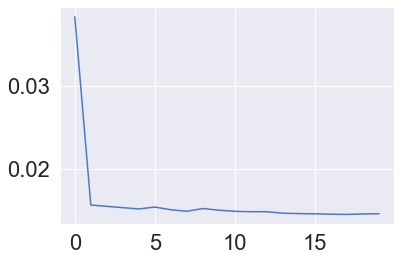

50/50 [==============================] - 0s 6ms/step - loss: 1.9164e-15


MAE   MSE  MAPE
Train 4.19 32.23  4.69
Test  2.92 10.81  2.96

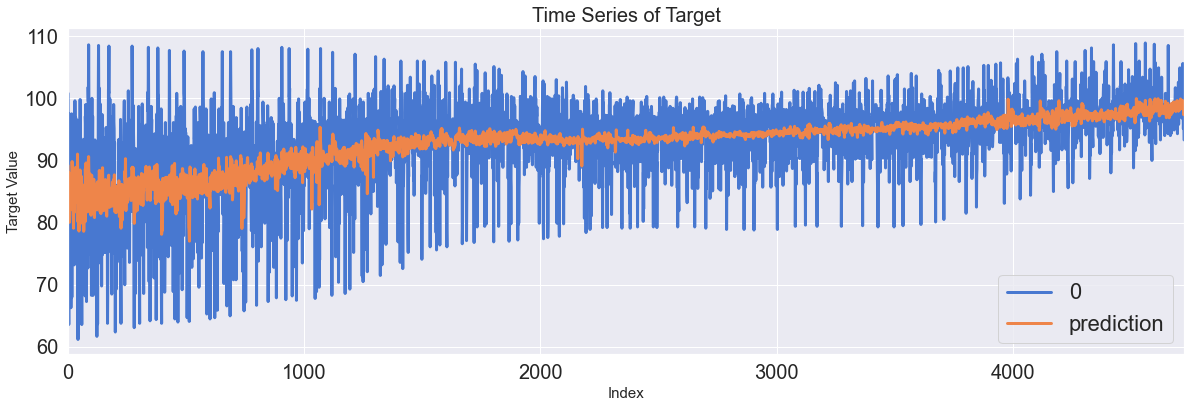

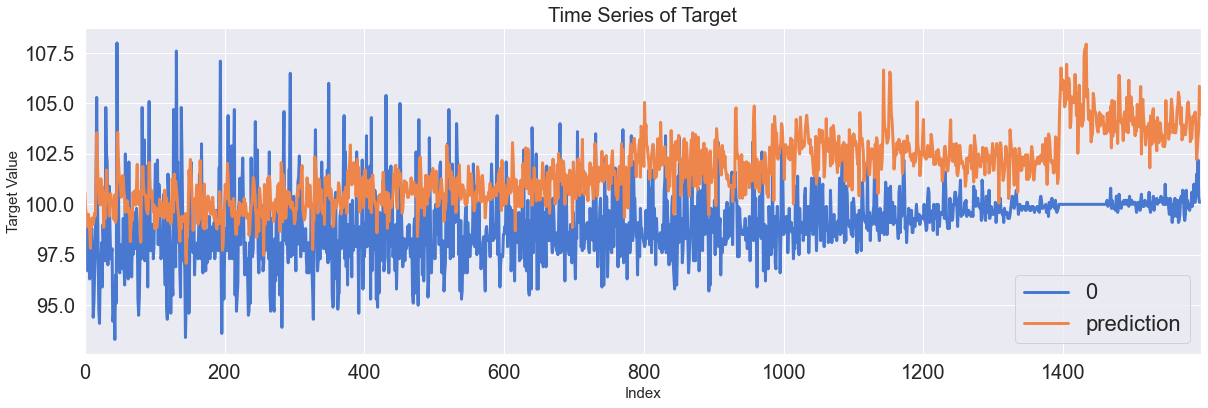

In [ ]:
# Data Loading
location = './Data/RealestateKorea_Gangnam/Economy.csv'
raw_all = pd.read_csv(location)
raw_all

# Feature Engineering
raw_all['Date'] = pd.to_datetime(raw_all['Date'])
raw_all.index = raw_all['Date']
raw_all = raw_all[raw_all.index >= '2010-01-01']
raw_all = raw_all[raw_all.index <= '2017-12-31']
raw_all.fillna(method='bfill', inplace=True)

# Data Split
Y_colname = ['Price']
X_remove = ['Date', 'Price_Sido']
X_colname = [x for x in raw_all.columns if x not in Y_colname+X_remove]
X_train, X_test, Y_train, Y_test = datasplit_ts(raw_all, Y_colname, X_colname, '2016-01-01')

# Parameters
scaler_X_tr = preprocessing.MinMaxScaler()
scaler_Y_tr = preprocessing.MinMaxScaler()
sequence = 34
batch_size = 32
epoch = 20
verbose = 1
dropout_ratio = 0

# Feature Engineering
## Scaling
X_train_scaled = scaler_X_tr.fit_transform(X_train)
Y_train_scaled = scaler_Y_tr.fit_transform(Y_train)
X_test_scaled = scaler_X_tr.transform(X_test)
Y_test_scaled = scaler_Y_tr.transform(Y_test)

## X / Y Split
X_train, Y_train = [], []
for index in range(len(X_train_scaled) - sequence):
    X_train.append(np.array(X_train_scaled[index: index + sequence]))
    Y_train.append(np.ravel(Y_train_scaled[index + sequence:index + sequence + 1]))
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_test, Y_test = [], []
for index in range(len(X_test_scaled) - sequence):
    X_test.append(np.array(X_test_scaled[index: index + sequence]))
    Y_test.append(np.ravel(Y_test_scaled[index + sequence:index + sequence + 1]))  
X_test, Y_test = np.array(X_test), np.array(Y_test) 

## Retype and Reshape
X_train = X_train.reshape(X_train.shape[0], sequence, -1)
X_test = X_test.reshape(X_test.shape[0], sequence, -1)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# GRU
model = Sequential()
model.add(GRU(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
model.add(Dropout(dropout_ratio)) 
# model.add(GRU(256, return_sequences=True, activation="relu"))
# model.add(Dropout(dropout_ratio)) 
# model.add(GRU(128, return_sequences=True, activation="relu"))
# model.add(Dropout(dropout_ratio)) 
model.add(GRU(64, return_sequences=False, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
model_fit = model.fit(X_train, Y_train, 
                      batch_size=batch_size, epochs=epoch,
                      verbose=verbose)

plt.plot(pd.DataFrame(model_fit.history))
plt.grid(True)
plt.show()

# prediction
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

# evaluation
result = model.evaluate(X_test, Y_test_pred)
if scaler_Y_tr != []:
    Y_train = scaler_Y_tr.inverse_transform(Y_train)
    Y_train_pred = scaler_Y_tr.inverse_transform(Y_train_pred)
    Y_test = scaler_Y_tr.inverse_transform(Y_test)
    Y_test_pred = scaler_Y_tr.inverse_transform(Y_test_pred)
Score_GRU, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), 
                                                      pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=True)
display(Score_GRU)

# error analysis
# error_analysis(Residual_te, ['Error'], X_test_feR.reset_index().iloc[:,1:].loc[Residual_te.index], graph_on=True)

#### Other Case1:

In [10]:
# 여기서 보면 과연 강남구의 아파트 가격에 계속 frequency가 빈번하게 흔들리는 것이 맞는ㄴ가?
# 이는 강남구내의 Region 마다 Building Type (빌라.아파트) 등을 합쳐서 들어있는 것이므로
# 데이터 전처리가 필요함

raw_all

Price       Date  Region  Price_Sido  Year  Month  Building_Type  \
Date                                                                           
2010-01-01  93.40 2010-01-01   45000       93.30  2010      1              7   
2010-01-01  83.90 2010-01-01   30000       83.10  2010      1              0   
2010-01-01  92.70 2010-01-01   30000       92.30  2010      1              7   
2010-01-01  80.80 2010-01-01   30000       79.70  2010      1              1   
2010-01-01  81.80 2010-01-01   30000       81.80  2010      1              3   
...           ...        ...     ...         ...   ...    ...            ...   
2017-12-01 102.20 2017-12-01   11000      100.80  2017     12              1   
2017-12-01 100.40 2017-12-01   41000      100.20  2017     12              7   
2017-12-01 100.10 2017-12-01   41000      100.10  2017     12              3   
2017-12-01 100.10 2017-12-01   41000      100.00  2017     12              1   
2017-12-01 100.10 2017-12-01   41000      100.10  2017     12              0   

            Construction_Amount  CD_Rate  Deposit_Rate  Exchange_Rate  \
Date                                                                    
2010-01-01         6,500,576.00     2.88          3.93       1,156.50   
2010-01-01         6,500,576.00     2.88          3.93       1,156.50   
2010-01-01         6,500,576.00     2.88          3.93       1,156.50   
2010-01-01         6,500,576.00     2.88          3.93       1,156.50   
2010-01-01         6,500,576.00     2.88          3.93       1,156.50   
...                         ...      ...           ...            ...   
2017-12-01        14,536,308.00     1.66          1.78       1,071.40   
2017-12-01        14,536,308.00     1.66          1.78       1,071.40   
2017-12-01        14,536,308.00     1.66          1.78       1,071.40   
2017-12-01        14,536,308.00     1.66          1.78       1,071.40   
2017-12-01        14,536,308.00     1.66          1.78       1,071.40   

            Composite_Stock_Price  Economy_Growth  Exchequer_Bond_3Y  \
Date                                                                   
2010-01-01               1,682.16            2.20               4.29   
2010-01-01               1,682.16            2.20               4.29   
2010-01-01               1,682.16            2.20               4.29   
2010-01-01               1,682.16            2.20               4.29   
2010-01-01               1,682.16            2.20               4.29   
...                           ...             ...                ...   
2017-12-01               2,467.73           -0.20               2.10   
2017-12-01               2,467.73           -0.20               2.10   
2017-12-01               2,467.73           -0.20               2.10   
2017-12-01               2,467.73           -0.20               2.10   
2017-12-01               2,467.73           -0.20               2.10   

            Household_Loan_All  Mortgage_All  Number_Of_Nosells  Unsalenum  
Date                                                                        
2010-01-01          548,723.30    338,666.30               0.00       0.00  
2010-01-01          548,723.30    338,666.30           3,042.00     323.00  
2010-01-01          548,723.30    338,666.30           3,042.00     323.00  
2010-01-01          548,723.30    338,666.30           3,042.00     323.00  
2010-01-01          548,723.30    338,666.30           3,042.00     323.00  
...                        ...           ...                ...        ...  
2017-12-01          974,569.50    578,312.90               2.00       2.00  
2017-12-01          974,569.50    578,312.90               0.00       0.00  
2017-12-01          974,569.50    578,312.90               0.00       0.00  
2017-12-01          974,569.50    578,312.90               0.00       0.00  
2017-12-01          974,569.50    578,312.90               0.00       0.00  

[6392 rows x 18 columns]

In [19]:
# Data Loading
# 데이터 부분을 전처리함
# 빌딩
location = './Economy.csv'
raw_all = pd.read_csv(location)
date = raw_all['Date'].unique()
# year와 month로 그륩을 나눠준다.
# 이렇게 하면 Region과 Building_TYPE이위에서 보면 여러가지가 홉합해 있는 것에서 거의 대부분 평균으로 변하게 되어 몇가지 특정한 값만을 가지게 한다.
# 이 목적은 Region과 Building Type에 대한 영향도를 감소시키기 위하여 평균을 사용한 것이다.
raw_all = raw_all.groupby(['Year', 'Month']).mean()
raw_all


Price    Region  Price_Sido  Building_Type  Construction_Amount  \
Year Month                                                                    
2006 1      75.17 36,750.00       75.05           2.75         4,867,793.00   
     2      75.46 36,750.00       75.17           2.75         4,862,500.00   
     3      75.72 36,750.00       75.46           2.75         6,313,640.00   
     4      75.98 36,750.00       75.72           2.75         6,303,213.00   
     5      76.12 36,750.00       75.98           2.75         6,410,478.00   
...           ...       ...         ...            ...                  ...   
2018 6     100.15 36,705.88      100.17           2.75        12,821,605.00   
     7     100.11 36,705.88      100.15           2.75        10,891,515.00   
     8     100.23 36,705.88      100.11           2.75                  NaN   
     9     100.34 36,705.88      100.23           2.75                  NaN   
     10    100.46 36,705.88      100.34           2.75                  NaN   

            CD_Rate  Deposit_Rate  Exchange_Rate  Composite_Stock_Price  \
Year Month                                                                
2006 1         4.15          4.06         971.00               1,379.32   
     2         4.25          4.13         969.00               1,341.72   
     3         4.27          4.20         975.90               1,331.72   
     4         4.33          4.33         945.70               1,415.92   
     5         4.36          4.31         947.40               1,388.83   
...             ...           ...            ...                    ...   
2018 6         1.65          1.83       1,121.70               2,394.51   
     7         1.65          1.79       1,116.70               2,284.25   
     8         1.65           NaN       1,108.80                    NaN   
     9          NaN           NaN            NaN                    NaN   
     10         NaN           NaN            NaN                    NaN   

            Economy_Growth  Exchequer_Bond_3Y  Household_Loan_All  \
Year Month                                                          
2006 1                1.80               5.02                 NaN   
     2                1.80               4.87                 NaN   
     3                1.80               4.93                 NaN   
     4                0.60               4.95                 NaN   
     5                0.60               4.78                 NaN   
...                    ...                ...                 ...   
2018 6                 NaN               2.18          998,893.00   
     7                 NaN               2.10                 NaN   
     8                 NaN               2.02                 NaN   
     9                 NaN                NaN                 NaN   
     10                NaN                NaN                 NaN   

            Mortgage_All  Number_Of_Nosells  Unsalenum  
Year Month                                              
2006 1               NaN                NaN        NaN  
     2               NaN                NaN        NaN  
     3               NaN                NaN        NaN  
     4               NaN                NaN        NaN  
     5               NaN                NaN        NaN  
...                  ...                ...        ...  
2018 6        587,660.80             304.33      61.24  
     7               NaN             575.88     148.53  
     8               NaN             311.24     103.00  
     9               NaN             490.56      92.75  
     10              NaN             561.75      62.25  

[154 rows x 15 columns]

In [20]:
# 위에서 year과 month 축을 날리고 그 뒤에 있는 것 부터사용하고
raw_all = raw_all.groupby(['Year', 'Month']).mean().reset_index().iloc[:,2:]
# 위에서 date 정보를 빼놧던 것을 다시 행에 추가한다. 
raw_all['Date'] = date
# 이렇게 하면 엄청난 단점이 6392개 였던 것이 154개로 줄어들기 때문에 데이터를 다 사용하지 못하는 부분이 많음
raw_all


Price    Region  Price_Sido  Building_Type  Construction_Amount  CD_Rate  \
0    75.17 36,750.00       75.05           2.75         4,867,793.00     4.15   
1    75.46 36,750.00       75.17           2.75         4,862,500.00     4.25   
2    75.72 36,750.00       75.46           2.75         6,313,640.00     4.27   
3    75.98 36,750.00       75.72           2.75         6,303,213.00     4.33   
4    76.12 36,750.00       75.98           2.75         6,410,478.00     4.36   
..     ...       ...         ...            ...                  ...      ...   
149 100.15 36,705.88      100.17           2.75        12,821,605.00     1.65   
150 100.11 36,705.88      100.15           2.75        10,891,515.00     1.65   
151 100.23 36,705.88      100.11           2.75                  NaN     1.65   
152 100.34 36,705.88      100.23           2.75                  NaN      NaN   
153 100.46 36,705.88      100.34           2.75                  NaN      NaN   

     Deposit_Rate  Exchange_Rate  Composite_Stock_Price  Economy_Growth  \
0            4.06         971.00               1,379.32            1.80   
1            4.13         969.00               1,341.72            1.80   
2            4.20         975.90               1,331.72            1.80   
3            4.33         945.70               1,415.92            0.60   
4            4.31         947.40               1,388.83            0.60   
..            ...            ...                    ...             ...   
149          1.83       1,121.70               2,394.51             NaN   
150          1.79       1,116.70               2,284.25             NaN   
151           NaN       1,108.80                    NaN             NaN   
152           NaN            NaN                    NaN             NaN   
153           NaN            NaN                    NaN             NaN   

     Exchequer_Bond_3Y  Household_Loan_All  Mortgage_All  Number_Of_Nosells  \
0                 5.02                 NaN           NaN                NaN   
1                 4.87                 NaN           NaN                NaN   
2                 4.93                 NaN           NaN                NaN   
3                 4.95                 NaN           NaN                NaN   
4                 4.78                 NaN           NaN                NaN   
..                 ...                 ...           ...                ...   
149               2.18          998,893.00    587,660.80             304.33   
150               2.10                 NaN           NaN             575.88   
151               2.02                 NaN           NaN             311.24   
152                NaN                 NaN           NaN             490.56   
153                NaN                 NaN           NaN             561.75   

     Unsalenum        Date  
0          NaN  2006-01-01  
1          NaN  2006-02-01  
2          NaN  2006-03-01  
3          NaN  2006-04-01  
4          NaN  2006-05-01  
..         ...         ...  
149      61.24  2018-06-01  
150     148.53  2018-07-01  
151     103.00  2018-08-01  
152      92.75  2018-09-01  
153      62.25  2018-10-01  

[154 rows x 16 columns]

Train_size: (72, 16) Test_size: (24, 16)
X_train: (72, 11) Y_train: (72, 1)
X_test: (24, 11) Y_test: (24, 1)
X_train: (60, 12, 11) Y_train: (60, 1)
X_test: (12, 12, 11) Y_test: (12, 1)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 12, 128)           54144     
                                                                 
 dropout_10 (Dropout)        (None, 12, 128)           0         
                                                                 
 gru_5 (GRU)                 (None, 12, 256)           296448    
                                                                 
 dropout_11 (Dropout)        (None, 12, 256)           0         
                                                                 
 gru_6 (GRU)                 (None, 12, 128)           148224    
                                                                 
 

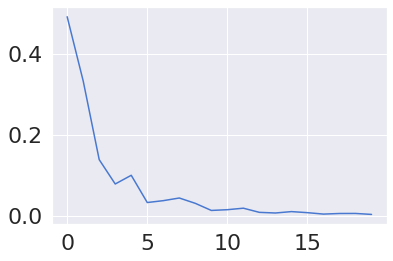

1/1 [==============================] - 1s 1s/step - loss: 5.9212e-15


MAE   MSE  MAPE
Train 0.61  0.60  0.66
Test  4.53 21.17  4.55

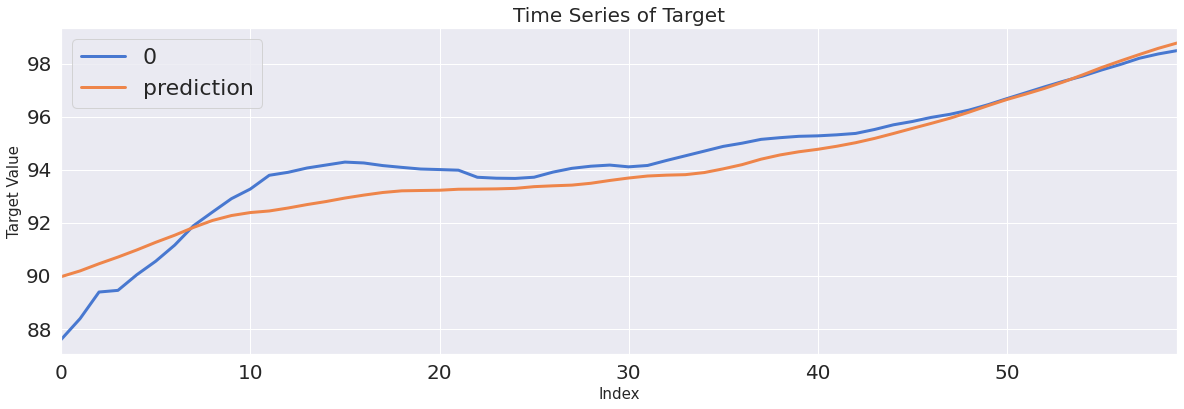

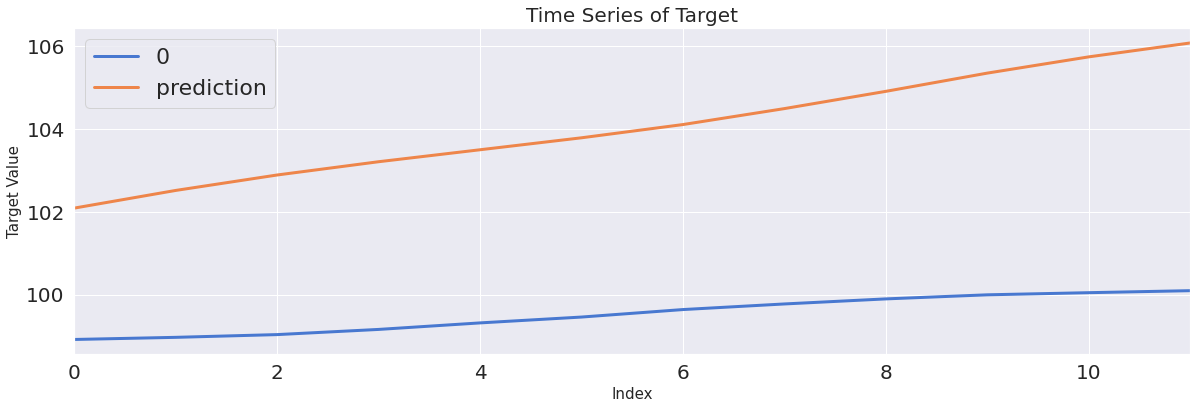

In [21]:
# Feature Engineering
raw_all['Date'] = pd.to_datetime(raw_all['Date'])
raw_all.index = raw_all['Date']
raw_all = raw_all[raw_all.index >= '2010-01-01']
raw_all = raw_all[raw_all.index <= '2017-12-31']
raw_all.fillna(method='bfill', inplace=True)

# Data Split
Y_colname = ['Price']
X_remove = ['Date', 'Region', 'Price_Sido', 'Building_Type']
X_colname = [x for x in raw_all.columns if x not in Y_colname+X_remove]
X_train, X_test, Y_train, Y_test = datasplit_ts(raw_all, Y_colname, X_colname, '2016-01-01')

# Parameters
# 위와 동일한데 sequnce와 batch size만 다르게 해서 parameter를 찾음

scaler_X_tr = preprocessing.MinMaxScaler()
scaler_Y_tr = preprocessing.MinMaxScaler()
sequence = 12
batch_size = 32
epoch = 20
verbose = 1
dropout_ratio = 0

# Feature Engineering
## Scaling
X_train_scaled = scaler_X_tr.fit_transform(X_train)
Y_train_scaled = scaler_Y_tr.fit_transform(Y_train)
X_test_scaled = scaler_X_tr.transform(X_test)
Y_test_scaled = scaler_Y_tr.transform(Y_test)

## X / Y Split
X_train, Y_train = [], []
for index in range(len(X_train_scaled) - sequence):
    X_train.append(np.array(X_train_scaled[index: index + sequence]))
    Y_train.append(np.ravel(Y_train_scaled[index + sequence:index + sequence + 1]))
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_test, Y_test = [], []
for index in range(len(X_test_scaled) - sequence):
    X_test.append(np.array(X_test_scaled[index: index + sequence]))
    Y_test.append(np.ravel(Y_test_scaled[index + sequence:index + sequence + 1]))  
X_test, Y_test = np.array(X_test), np.array(Y_test) 

## Retype and Reshape
X_train = X_train.reshape(X_train.shape[0], sequence, -1)
X_test = X_test.reshape(X_test.shape[0], sequence, -1)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# GRU
model = Sequential()
model.add(GRU(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
model.add(Dropout(dropout_ratio)) 
model.add(GRU(256, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(GRU(128, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(GRU(64, return_sequences=False, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
model_fit = model.fit(X_train, Y_train, 
                      batch_size=batch_size, epochs=epoch,
                      verbose=verbose)

plt.plot(pd.DataFrame(model_fit.history))
plt.grid(True)
plt.show()

# prediction
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

# evaluation
result = model.evaluate(X_test, Y_test_pred)
if scaler_Y_tr != []:
    Y_train = scaler_Y_tr.inverse_transform(Y_train)
    Y_train_pred = scaler_Y_tr.inverse_transform(Y_train_pred)
    Y_test = scaler_Y_tr.inverse_transform(Y_test)
    Y_test_pred = scaler_Y_tr.inverse_transform(Y_test_pred)
Score_GRU, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), 
                                                      pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=True)
display(Score_GRU)

# error analysis
# error_analysis(Residual_te, ['Error'], X_test_feR.reset_index().iloc[:,1:].loc[Residual_te.index], graph_on=True)

#### Optimal Sequence

In [ ]:
# Data Loading
location = './Economy.csv'
raw_all = pd.read_csv(location)
date = raw_all['Date'].unique()
raw_all = raw_all.groupby(['Year', 'Month']).mean().reset_index().iloc[:,2:]
raw_all['Date'] = date
raw_all

# Feature Engineering
raw_all['Date'] = pd.to_datetime(raw_all['Date'])
raw_all.index = raw_all['Date']
raw_all = raw_all[raw_all.index >= '2010-01-01']
raw_all = raw_all[raw_all.index <= '2017-12-31']
raw_all.fillna(method='bfill', inplace=True)

# Data Split
Y_colname = ['Price']
X_remove = ['Date', 'Region', 'Price_Sido', 'Building_Type']
X_colname = [x for x in raw_all.columns if x not in Y_colname+X_remove]
X_train, X_test, Y_train, Y_test = datasplit_ts(raw_all, Y_colname, X_colname, '2016-01-01')

# Parameters
scaler_X_tr = preprocessing.MinMaxScaler()
scaler_Y_tr = preprocessing.MinMaxScaler()
sequence = 12
batch_size = 32
epoch = 20
verbose = 0
dropout_ratio = 0

# Feature Engineering
## Scaling
X_train_scaled = scaler_X_tr.fit_transform(X_train)
Y_train_scaled = scaler_Y_tr.fit_transform(Y_train)
X_test_scaled = scaler_X_tr.transform(X_test)
Y_test_scaled = scaler_Y_tr.transform(Y_test)

####################### iterations #######################
#### 다 동일한데 sequnce 사이즈를 다 돌면서 실행해서 어떤갑이 좋은 지 확인해본다.
Score = dict()
seqsize_list = [i for i in range(1, 15, 1)]
for i in tqdm(seqsize_list):
    sequence = i

    ## X / Y Split
    X_train, Y_train = [], []
    for index in range(len(X_train_scaled) - sequence):
        X_train.append(np.array(X_train_scaled[index: index + sequence]))
        Y_train.append(np.ravel(Y_train_scaled[index + sequence:index + sequence + 1]))
    X_train, Y_train = np.array(X_train), np.array(Y_train)
    X_test, Y_test = [], []
    for index in range(len(X_test_scaled) - sequence):
        X_test.append(np.array(X_test_scaled[index: index + sequence]))
        Y_test.append(np.ravel(Y_test_scaled[index + sequence:index + sequence + 1]))  
    X_test, Y_test = np.array(X_test), np.array(Y_test) 

    ## Retype and Reshape
    X_train = X_train.reshape(X_train.shape[0], sequence, -1)
    X_test = X_test.reshape(X_test.shape[0], sequence, -1)
    print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
    print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

    # GRU
    model = Sequential()
    model.add(GRU(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
    model.add(Dropout(dropout_ratio)) 
    model.add(GRU(256, return_sequences=True, activation="relu"))
    model.add(Dropout(dropout_ratio)) 
    model.add(GRU(128, return_sequences=True, activation="relu"))
    model.add(Dropout(dropout_ratio)) 
    model.add(GRU(64, return_sequences=False, activation="relu"))
    model.add(Dropout(dropout_ratio)) 
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    # model.summary()
    model_fit = model.fit(X_train, Y_train, 
                          batch_size=batch_size, epochs=epoch,
                          verbose=verbose)

    # plt.plot(pd.DataFrame(model_fit.history))
    # plt.grid(True)
    # plt.show()

    # prediction
    Y_train_pred = model.predict(X_train)
    Y_test_pred = model.predict(X_test)

    # evaluation
    result = model.evaluate(X_test, Y_test_pred)
    if scaler_Y_tr != []:
        Y_train = scaler_Y_tr.inverse_transform(Y_train)
        Y_train_pred = scaler_Y_tr.inverse_transform(Y_train_pred)
        Y_test = scaler_Y_tr.inverse_transform(Y_test)
        Y_test_pred = scaler_Y_tr.inverse_transform(Y_test_pred)
    Score_GRU, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), 
                                                          pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=False)
#     display(Score_GRU)
    Score[str(sequence)] = Score_GRU

    # error analysis
    # error_analysis(Residual_te, ['Error'], X_test_feR.reset_index().iloc[:,1:].loc[Residual_te.index], graph_on=True)

  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

Train_size: (72, 16) Test_size: (24, 16)
X_train: (72, 11) Y_train: (72, 1)
X_test: (24, 11) Y_test: (24, 1)
X_train: (71, 1, 11) Y_train: (71, 1)
X_test: (23, 1, 11) Y_test: (23, 1)
1/1 [==============================] - 0s 997us/step - loss: 1.2357e-14


  7%|█████▉                                                                             | 1/14 [00:05<01:17,  5.94s/it]

X_train: (70, 2, 11) Y_train: (70, 1)
X_test: (22, 2, 11) Y_test: (22, 1)
1/1 [==============================] - 0s 998us/step - loss: 5.3291e-15


 14%|███████████▊                                                                       | 2/14 [00:11<01:10,  5.84s/it]

X_train: (69, 3, 11) Y_train: (69, 1)
X_test: (21, 3, 11) Y_test: (21, 1)
1/1 [==============================] - 0s 997us/step - loss: 1.1504e-14


 21%|█████████████████▊                                                                 | 3/14 [00:17<01:04,  5.84s/it]

X_train: (68, 4, 11) Y_train: (68, 1)
X_test: (20, 4, 11) Y_test: (20, 1)
1/1 [==============================] - 0s 997us/step - loss: 6.3949e-15


 29%|███████████████████████▋                                                           | 4/14 [00:23<00:59,  5.99s/it]

X_train: (67, 5, 11) Y_train: (67, 1)
X_test: (19, 5, 11) Y_test: (19, 1)
1/1 [==============================] - 0s 997us/step - loss: 5.9835e-15


 36%|█████████████████████████████▋                                                     | 5/14 [00:29<00:53,  5.99s/it]

X_train: (66, 6, 11) Y_train: (66, 1)
X_test: (18, 6, 11) Y_test: (18, 1)
1/1 [==============================] - 0s 998us/step - loss: 5.5264e-15


 43%|███████████████████████████████████▌                                               | 6/14 [00:35<00:48,  6.06s/it]

X_train: (65, 7, 11) Y_train: (65, 1)
X_test: (17, 7, 11) Y_test: (17, 1)
1/1 [==============================] - 0s 998us/step - loss: 9.1953e-15


 50%|█████████████████████████████████████████▌                                         | 7/14 [00:42<00:42,  6.10s/it]

X_train: (64, 8, 11) Y_train: (64, 1)
X_test: (16, 8, 11) Y_test: (16, 1)
1/1 [==============================] - 0s 997us/step - loss: 7.9936e-15


 57%|███████████████████████████████████████████████▍                                   | 8/14 [00:47<00:34,  5.79s/it]

X_train: (63, 9, 11) Y_train: (63, 1)
X_test: (15, 9, 11) Y_test: (15, 1)
1/1 [==============================] - 0s 998us/step - loss: 8.5265e-15


 64%|█████████████████████████████████████████████████████▎                             | 9/14 [00:53<00:29,  5.91s/it]

X_train: (62, 10, 11) Y_train: (62, 1)
X_test: (14, 10, 11) Y_test: (14, 1)
1/1 [==============================] - 0s 2ms/step - loss: 8.1205e-15


 71%|██████████████████████████████████████████████████████████▌                       | 10/14 [00:59<00:24,  6.00s/it]

X_train: (61, 11, 11) Y_train: (61, 1)
X_test: (13, 11, 11) Y_test: (13, 1)
1/1 [==============================] - 0s 998us/step - loss: 5.4657e-15


 79%|████████████████████████████████████████████████████████████████▍                 | 11/14 [01:05<00:18,  6.08s/it]

X_train: (60, 12, 11) Y_train: (60, 1)
X_test: (12, 12, 11) Y_test: (12, 1)
1/1 [==============================] - 0s 1ms/step - loss: 1.6579e-14


 86%|██████████████████████████████████████████████████████████████████████▎           | 12/14 [01:12<00:12,  6.15s/it]

X_train: (59, 13, 11) Y_train: (59, 1)
X_test: (11, 13, 11) Y_test: (11, 1)
1/1 [==============================] - 0s 999us/step - loss: 6.4595e-15


 93%|████████████████████████████████████████████████████████████████████████████▏     | 13/14 [01:18<00:06,  6.21s/it]

X_train: (58, 14, 11) Y_train: (58, 1)
X_test: (10, 14, 11) Y_test: (10, 1)
1/1 [==============================] - 0s 997us/step - loss: 1.9895e-14


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:24<00:00,  6.06s/it]


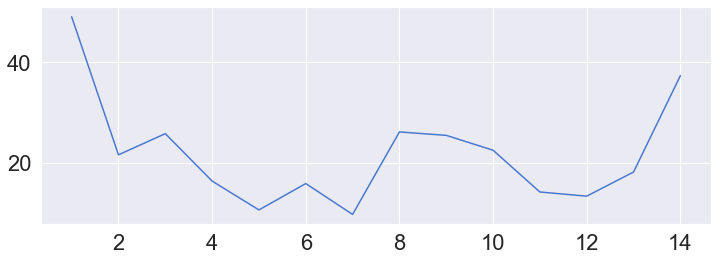

In [ ]:
# Performance plot by sequence length
seq_test = pd.DataFrame()
for key, val in Score.items():
    seq_test = pd.concat([seq_test, val.iloc[1,:].T], axis=1)

seq_test = seq_test.T
seq_test.index = seqsize_list
seq_test['MSE'].plot(figsize=(12,4))
plt.show()

#### Optimal Batchsize

In [ ]:
# Data Loading
location = './Economy.csv'
raw_all = pd.read_csv(location)
date = raw_all['Date'].unique()
raw_all = raw_all.groupby(['Year', 'Month']).mean().reset_index().iloc[:,2:]
raw_all['Date'] = date
raw_all

# Feature Engineering
raw_all['Date'] = pd.to_datetime(raw_all['Date'])
raw_all.index = raw_all['Date']
raw_all = raw_all[raw_all.index >= '2010-01-01']
raw_all = raw_all[raw_all.index <= '2017-12-31']
raw_all.fillna(method='bfill', inplace=True)

# Data Split
Y_colname = ['Price']
X_remove = ['Date', 'Region', 'Price_Sido', 'Building_Type']
X_colname = [x for x in raw_all.columns if x not in Y_colname+X_remove]
X_train, X_test, Y_train, Y_test = datasplit_ts(raw_all, Y_colname, X_colname, '2016-01-01')

# Parameters
scaler_X_tr = preprocessing.MinMaxScaler()
scaler_Y_tr = preprocessing.MinMaxScaler()
sequence = 4
batch_size = 32
epoch = 20
verbose = 0
dropout_ratio = 0

# Feature Engineering
## Scaling
X_train_scaled = scaler_X_tr.fit_transform(X_train)
Y_train_scaled = scaler_Y_tr.fit_transform(Y_train)
X_test_scaled = scaler_X_tr.transform(X_test)
Y_test_scaled = scaler_Y_tr.transform(Y_test)

####################### iterations #######################
Score = dict()
batchsize_list = [i for i in range(5, 50, 5)]
for i in tqdm(batchsize_list):
    batch_size = i

    ## X / Y Split
    X_train, Y_train = [], []
    for index in range(len(X_train_scaled) - sequence):
        X_train.append(np.array(X_train_scaled[index: index + sequence]))
        Y_train.append(np.ravel(Y_train_scaled[index + sequence:index + sequence + 1]))
    X_train, Y_train = np.array(X_train), np.array(Y_train)
    X_test, Y_test = [], []
    for index in range(len(X_test_scaled) - sequence):
        X_test.append(np.array(X_test_scaled[index: index + sequence]))
        Y_test.append(np.ravel(Y_test_scaled[index + sequence:index + sequence + 1]))  
    X_test, Y_test = np.array(X_test), np.array(Y_test) 

    ## Retype and Reshape
    X_train = X_train.reshape(X_train.shape[0], sequence, -1)
    X_test = X_test.reshape(X_test.shape[0], sequence, -1)
    print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
    print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

    # GRU
    model = Sequential()
    model.add(GRU(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
    model.add(Dropout(dropout_ratio)) 
    model.add(GRU(256, return_sequences=True, activation="relu"))
    model.add(Dropout(dropout_ratio)) 
    model.add(GRU(128, return_sequences=True, activation="relu"))
    model.add(Dropout(dropout_ratio)) 
    model.add(GRU(64, return_sequences=False, activation="relu"))
    model.add(Dropout(dropout_ratio)) 
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    # model.summary()
    model_fit = model.fit(X_train, Y_train, 
                          batch_size=batch_size, epochs=epoch,
                          verbose=verbose)

    # plt.plot(pd.DataFrame(model_fit.history))
    # plt.grid(True)
    # plt.show()

    # prediction
    Y_train_pred = model.predict(X_train)
    Y_test_pred = model.predict(X_test)

    # evaluation
    result = model.evaluate(X_test, Y_test_pred)
    if scaler_Y_tr != []:
        Y_train = scaler_Y_tr.inverse_transform(Y_train)
        Y_train_pred = scaler_Y_tr.inverse_transform(Y_train_pred)
        Y_test = scaler_Y_tr.inverse_transform(Y_test)
        Y_test_pred = scaler_Y_tr.inverse_transform(Y_test_pred)
    Score_GRU, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), 
                                                          pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=False)
#     display(Score_GRU)
    Score[str(batch_size)] = Score_GRU

    # error analysis
    # error_analysis(Residual_te, ['Error'], X_test_feR.reset_index().iloc[:,1:].loc[Residual_te.index], graph_on=True)

  0%|                                                                                            | 0/9 [00:00<?, ?it/s]

Train_size: (72, 16) Test_size: (24, 16)
X_train: (72, 11) Y_train: (72, 1)
X_test: (24, 11) Y_test: (24, 1)
X_train: (68, 4, 11) Y_train: (68, 1)
X_test: (20, 4, 11) Y_test: (20, 1)
1/1 [==============================] - 0s 0s/step - loss: 7.1054e-15


 11%|█████████▎                                                                          | 1/9 [00:07<00:56,  7.12s/it]

X_train: (68, 4, 11) Y_train: (68, 1)
X_test: (20, 4, 11) Y_test: (20, 1)
1/1 [==============================] - 0s 0s/step - loss: 4.2633e-15


 22%|██████████████████▋                                                                 | 2/9 [00:13<00:48,  6.86s/it]

X_train: (68, 4, 11) Y_train: (68, 1)
X_test: (20, 4, 11) Y_test: (20, 1)
1/1 [==============================] - 0s 997us/step - loss: 4.9738e-15


 33%|████████████████████████████                                                        | 3/9 [00:19<00:39,  6.63s/it]

X_train: (68, 4, 11) Y_train: (68, 1)
X_test: (20, 4, 11) Y_test: (20, 1)
1/1 [==============================] - 0s 998us/step - loss: 9.9476e-15


 44%|█████████████████████████████████████▎                                              | 4/9 [00:25<00:32,  6.44s/it]

X_train: (68, 4, 11) Y_train: (68, 1)
X_test: (20, 4, 11) Y_test: (20, 1)
1/1 [==============================] - 0s 997us/step - loss: 8.5265e-15


 56%|██████████████████████████████████████████████▋                                     | 5/9 [00:31<00:25,  6.27s/it]

X_train: (68, 4, 11) Y_train: (68, 1)
X_test: (20, 4, 11) Y_test: (20, 1)
1/1 [==============================] - 0s 997us/step - loss: 9.9476e-15


 67%|████████████████████████████████████████████████████████                            | 6/9 [00:37<00:18,  6.28s/it]

X_train: (68, 4, 11) Y_train: (68, 1)
X_test: (20, 4, 11) Y_test: (20, 1)
1/1 [==============================] - 0s 2ms/step - loss: 6.3949e-15


 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [00:43<00:12,  6.11s/it]

X_train: (68, 4, 11) Y_train: (68, 1)
X_test: (20, 4, 11) Y_test: (20, 1)
1/1 [==============================] - 0s 998us/step - loss: 7.1054e-15


 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [00:49<00:05,  6.00s/it]

X_train: (68, 4, 11) Y_train: (68, 1)
X_test: (20, 4, 11) Y_test: (20, 1)
1/1 [==============================] - 0s 974us/step - loss: 7.1054e-15


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:54<00:00,  6.09s/it]


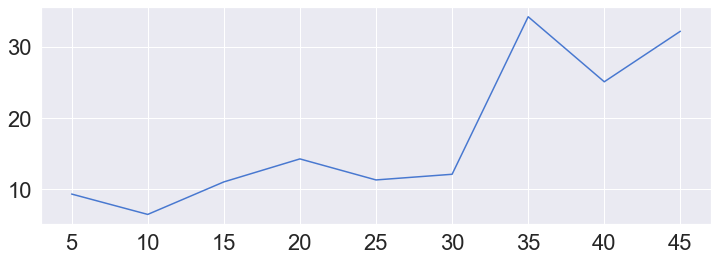

In [ ]:
# Performance plot by sequence length
seq_test = pd.DataFrame()
for key, val in Score.items():
    seq_test = pd.concat([seq_test, val.iloc[1,:].T], axis=1)

seq_test = seq_test.T
seq_test.index = batchsize_list
seq_test['MSE'].plot(figsize=(12,4))
plt.show()

#### Final

Train_size: (72, 16) Test_size: (24, 16)
X_train: (72, 11) Y_train: (72, 1)
X_test: (24, 11) Y_test: (24, 1)
X_train: (67, 5, 11) Y_train: (67, 1)
X_test: (19, 5, 11) Y_test: (19, 1)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_8 (GRU)                 (None, 5, 128)            54144     
                                                                 
 dropout_14 (Dropout)        (None, 5, 128)            0         
                                                                 
 gru_9 (GRU)                 (None, 5, 256)            296448    
                                                                 
 dropout_15 (Dropout)        (None, 5, 256)            0         
                                                                 
 gru_10 (GRU)                (None, 5, 128)            148224    
                                                                 
 dr

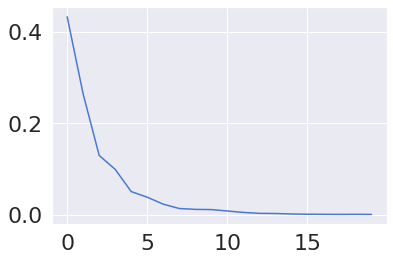

1/1 [==============================] - 1s 1s/step - loss: 3.7397e-15


MAE  MSE  MAPE
Train 0.35 0.20  0.38
Test  2.31 6.98  2.32

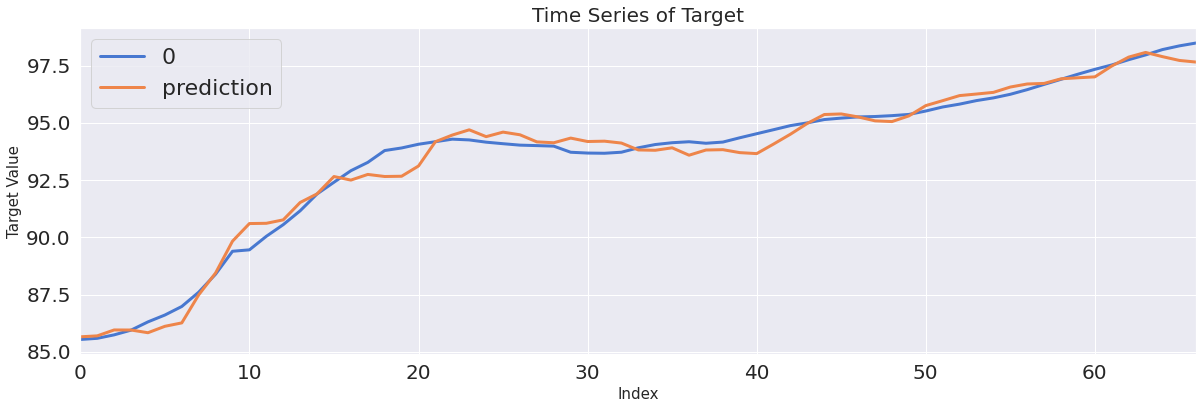

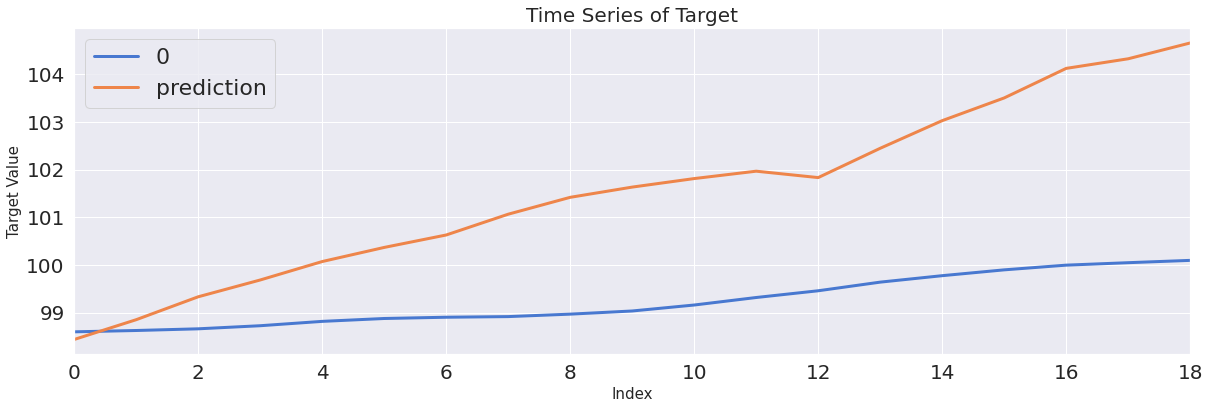

In [22]:
# Data Loading
location = './Economy.csv'
raw_all = pd.read_csv(location)
date = raw_all['Date'].unique()
raw_all = raw_all.groupby(['Year', 'Month']).mean().reset_index().iloc[:,2:]
raw_all['Date'] = date
raw_all

# Feature Engineering
raw_all['Date'] = pd.to_datetime(raw_all['Date'])
raw_all.index = raw_all['Date']
raw_all = raw_all[raw_all.index >= '2010-01-01']
raw_all = raw_all[raw_all.index <= '2017-12-31']
raw_all.fillna(method='bfill', inplace=True)

# Data Split
Y_colname = ['Price']
X_remove = ['Date', 'Region', 'Price_Sido', 'Building_Type']
X_colname = [x for x in raw_all.columns if x not in Y_colname+X_remove]
X_train, X_test, Y_train, Y_test = datasplit_ts(raw_all, Y_colname, X_colname, '2016-01-01')

# Parameters
scaler_X_tr = preprocessing.MinMaxScaler()
scaler_Y_tr = preprocessing.MinMaxScaler()
sequence = 5
batch_size = 25
epoch = 20
verbose = 1
dropout_ratio = 0

# Feature Engineering
## Scaling
X_train_scaled = scaler_X_tr.fit_transform(X_train)
Y_train_scaled = scaler_Y_tr.fit_transform(Y_train)
X_test_scaled = scaler_X_tr.transform(X_test)
Y_test_scaled = scaler_Y_tr.transform(Y_test)

## X / Y Split
X_train, Y_train = [], []
for index in range(len(X_train_scaled) - sequence):
    X_train.append(np.array(X_train_scaled[index: index + sequence]))
    Y_train.append(np.ravel(Y_train_scaled[index + sequence:index + sequence + 1]))
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_test, Y_test = [], []
for index in range(len(X_test_scaled) - sequence):
    X_test.append(np.array(X_test_scaled[index: index + sequence]))
    Y_test.append(np.ravel(Y_test_scaled[index + sequence:index + sequence + 1]))  
X_test, Y_test = np.array(X_test), np.array(Y_test) 

## Retype and Reshape
X_train = X_train.reshape(X_train.shape[0], sequence, -1)
X_test = X_test.reshape(X_test.shape[0], sequence, -1)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# GRU
model = Sequential()
model.add(GRU(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
model.add(Dropout(dropout_ratio)) 
model.add(GRU(256, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(GRU(128, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(GRU(64, return_sequences=False, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
model_fit = model.fit(X_train, Y_train, 
                      batch_size=batch_size, epochs=epoch,
                      verbose=verbose)

plt.plot(pd.DataFrame(model_fit.history))
plt.grid(True)
plt.show()

# prediction
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

# evaluation
result = model.evaluate(X_test, Y_test_pred)
if scaler_Y_tr != []:
    Y_train = scaler_Y_tr.inverse_transform(Y_train)
    Y_train_pred = scaler_Y_tr.inverse_transform(Y_train_pred)
    Y_test = scaler_Y_tr.inverse_transform(Y_test)
    Y_test_pred = scaler_Y_tr.inverse_transform(Y_test_pred)
Score_GRU, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), 
                                                      pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=True)
display(Score_GRU)

# error analysis
# error_analysis(Residual_te, ['Error'], X_test_feR.reset_index().iloc[:,1:].loc[Residual_te.index], graph_on=True)

#### Other Case2:

특정지역선택한 데이터 (154, 18)
Train_size: (72, 18) Test_size: (24, 18)
X_train: (72, 13) Y_train: (72, 1)
X_test: (24, 13) Y_test: (24, 1)
X_train: (60, 12, 13) Y_train: (60, 1)
X_test: (12, 12, 13) Y_test: (12, 1)
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_16 (GRU)                (None, 12, 128)           54912     
                                                                 
 dropout_22 (Dropout)        (None, 12, 128)           0         
                                                                 
 gru_17 (GRU)                (None, 12, 256)           296448    
                                                                 
 dropout_23 (Dropout)        (None, 12, 256)           0         
                                                                 
 gru_18 (GRU)                (None, 12, 128)           148224    
                                             

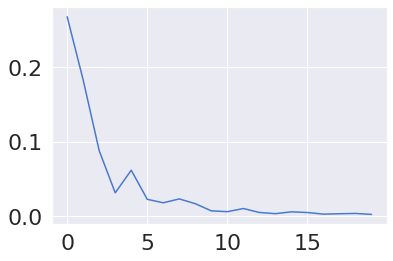

1/1 [==============================] - 1s 1s/step - loss: 4.7370e-15


MAE  MSE  MAPE
Train 0.81 0.98  0.94
Test  0.41 0.27  0.41

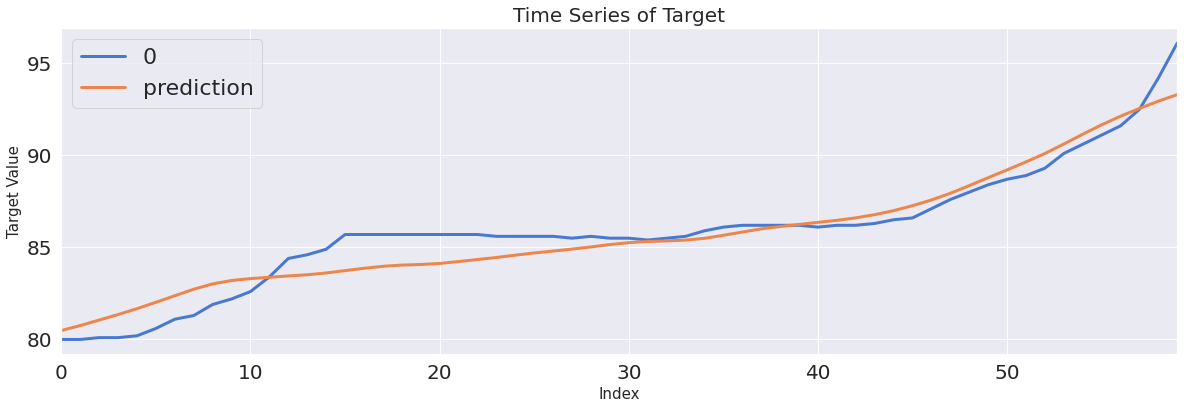

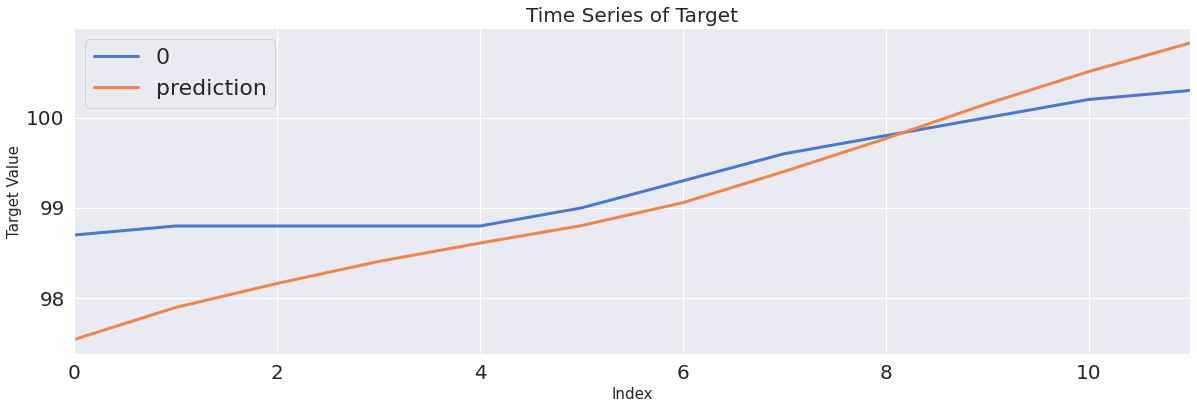

In [24]:
# Data Loading
location = './Economy.csv'
raw_all = pd.read_csv(location)
### 위에서는 평균을 썻지만 Region과 Bulding Type을 여기서는 그냥 고정하여 사용함
# 가장많은 것을 선택하던지 해서 딱 그 강남구내에 지역에 해당하는 것만 확인함.
raw_all = raw_all[(raw_all['Region'] == 50000) & (raw_all['Building_Type'] == 0)]
raw_all
print("특정지역선택한 데이터",raw_all.shape)

# Feature Engineering
raw_all['Date'] = pd.to_datetime(raw_all['Date'])
raw_all.index = raw_all['Date']
raw_all = raw_all[raw_all.index >= '2010-01-01']
raw_all = raw_all[raw_all.index <= '2017-12-31']
raw_all.fillna(method='bfill', inplace=True)

# Data Split
Y_colname = ['Price']
X_remove = ['Date', 'Region', 'Price_Sido', 'Building_Type']
X_colname = [x for x in raw_all.columns if x not in Y_colname+X_remove]
X_train, X_test, Y_train, Y_test = datasplit_ts(raw_all, Y_colname, X_colname, '2016-01-01')

# Parameters
scaler_X_tr = preprocessing.MinMaxScaler()
scaler_Y_tr = preprocessing.MinMaxScaler()
sequence = 12
batch_size = 32
epoch = 20
verbose = 1
dropout_ratio = 0

# Feature Engineering
## Scaling
X_train_scaled = scaler_X_tr.fit_transform(X_train)
Y_train_scaled = scaler_Y_tr.fit_transform(Y_train)
X_test_scaled = scaler_X_tr.transform(X_test)
Y_test_scaled = scaler_Y_tr.transform(Y_test)

## X / Y Split
X_train, Y_train = [], []
for index in range(len(X_train_scaled) - sequence):
    X_train.append(np.array(X_train_scaled[index: index + sequence]))
    Y_train.append(np.ravel(Y_train_scaled[index + sequence:index + sequence + 1]))
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_test, Y_test = [], []
for index in range(len(X_test_scaled) - sequence):
    X_test.append(np.array(X_test_scaled[index: index + sequence]))
    Y_test.append(np.ravel(Y_test_scaled[index + sequence:index + sequence + 1]))  
X_test, Y_test = np.array(X_test), np.array(Y_test) 

## Retype and Reshape
X_train = X_train.reshape(X_train.shape[0], sequence, -1)
X_test = X_test.reshape(X_test.shape[0], sequence, -1)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# GRU
model = Sequential()
model.add(GRU(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
model.add(Dropout(dropout_ratio)) 
model.add(GRU(256, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(GRU(128, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(GRU(64, return_sequences=False, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
model_fit = model.fit(X_train, Y_train, 
                      batch_size=batch_size, epochs=epoch,
                      verbose=verbose)

plt.plot(pd.DataFrame(model_fit.history))
plt.grid(True)
plt.show()

# prediction
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

# evaluation
result = model.evaluate(X_test, Y_test_pred)
if scaler_Y_tr != []:
    Y_train = scaler_Y_tr.inverse_transform(Y_train)
    Y_train_pred = scaler_Y_tr.inverse_transform(Y_train_pred)
    Y_test = scaler_Y_tr.inverse_transform(Y_test)
    Y_test_pred = scaler_Y_tr.inverse_transform(Y_test_pred)
Score_GRU, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), 
                                                      pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=True)
display(Score_GRU)

# error analysis
# error_analysis(Residual_te, ['Error'], X_test_feR.reset_index().iloc[:,1:].loc[Residual_te.index], graph_on=True)

#### Optimal Sequence

In [ ]:
# Data Loading
location = './Economy.csv'
raw_all = pd.read_csv(location)
raw_all = raw_all[(raw_all['Region'] == 50000) & (raw_all['Building_Type'] == 0)]
raw_all

# Feature Engineering
raw_all['Date'] = pd.to_datetime(raw_all['Date'])
raw_all.index = raw_all['Date']
raw_all = raw_all[raw_all.index >= '2010-01-01']
raw_all = raw_all[raw_all.index <= '2017-12-31']
raw_all.fillna(method='bfill', inplace=True)

# Data Split
Y_colname = ['Price']
X_remove = ['Date', 'Region', 'Price_Sido', 'Building_Type']
X_colname = [x for x in raw_all.columns if x not in Y_colname+X_remove]
X_train, X_test, Y_train, Y_test = datasplit_ts(raw_all, Y_colname, X_colname, '2016-01-01')

# Parameters
scaler_X_tr = preprocessing.MinMaxScaler()
scaler_Y_tr = preprocessing.MinMaxScaler()
sequence = 12
batch_size = 32
epoch = 20
verbose = 0
dropout_ratio = 0

# Feature Engineering
## Scaling
X_train_scaled = scaler_X_tr.fit_transform(X_train)
Y_train_scaled = scaler_Y_tr.fit_transform(Y_train)
X_test_scaled = scaler_X_tr.transform(X_test)
Y_test_scaled = scaler_Y_tr.transform(Y_test)

####################### iterations #######################
Score = dict()
seqsize_list = [i for i in range(1, 15, 1)]
for i in tqdm(seqsize_list):
    sequence = i

    ## X / Y Split
    X_train, Y_train = [], []
    for index in range(len(X_train_scaled) - sequence):
        X_train.append(np.array(X_train_scaled[index: index + sequence]))
        Y_train.append(np.ravel(Y_train_scaled[index + sequence:index + sequence + 1]))
    X_train, Y_train = np.array(X_train), np.array(Y_train)
    X_test, Y_test = [], []
    for index in range(len(X_test_scaled) - sequence):
        X_test.append(np.array(X_test_scaled[index: index + sequence]))
        Y_test.append(np.ravel(Y_test_scaled[index + sequence:index + sequence + 1]))  
    X_test, Y_test = np.array(X_test), np.array(Y_test) 

    ## Retype and Reshape
    X_train = X_train.reshape(X_train.shape[0], sequence, -1)
    X_test = X_test.reshape(X_test.shape[0], sequence, -1)
    print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
    print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

    # GRU
    model = Sequential()
    model.add(GRU(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
    model.add(Dropout(dropout_ratio)) 
    model.add(GRU(256, return_sequences=True, activation="relu"))
    model.add(Dropout(dropout_ratio)) 
    model.add(GRU(128, return_sequences=True, activation="relu"))
    model.add(Dropout(dropout_ratio)) 
    model.add(GRU(64, return_sequences=False, activation="relu"))
    model.add(Dropout(dropout_ratio)) 
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    # model.summary()
    model_fit = model.fit(X_train, Y_train, 
                          batch_size=batch_size, epochs=epoch,
                          verbose=verbose)

    # plt.plot(pd.DataFrame(model_fit.history))
    # plt.grid(True)
    # plt.show()

    # prediction
    Y_train_pred = model.predict(X_train)
    Y_test_pred = model.predict(X_test)

    # evaluation
    result = model.evaluate(X_test, Y_test_pred)
    if scaler_Y_tr != []:
        Y_train = scaler_Y_tr.inverse_transform(Y_train)
        Y_train_pred = scaler_Y_tr.inverse_transform(Y_train_pred)
        Y_test = scaler_Y_tr.inverse_transform(Y_test)
        Y_test_pred = scaler_Y_tr.inverse_transform(Y_test_pred)
    Score_GRU, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), 
                                                          pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=False)
#     display(Score_GRU)
    Score[str(sequence)] = Score_GRU

    # error analysis
    # error_analysis(Residual_te, ['Error'], X_test_feR.reset_index().iloc[:,1:].loc[Residual_te.index], graph_on=True)

  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

Train_size: (72, 18) Test_size: (24, 18)
X_train: (72, 13) Y_train: (72, 1)
X_test: (24, 13) Y_test: (24, 1)
X_train: (71, 1, 13) Y_train: (71, 1)
X_test: (23, 1, 13) Y_test: (23, 1)
1/1 [==============================] - 0s 0s/step - loss: 4.9429e-15


  7%|█████▉                                                                             | 1/14 [00:05<01:15,  5.79s/it]

X_train: (70, 2, 13) Y_train: (70, 1)
X_test: (22, 2, 13) Y_test: (22, 1)
1/1 [==============================] - 0s 997us/step - loss: 4.3601e-15


 14%|███████████▊                                                                       | 2/14 [00:10<01:07,  5.61s/it]

X_train: (69, 3, 13) Y_train: (69, 1)
X_test: (21, 3, 13) Y_test: (21, 1)
1/1 [==============================] - 0s 986us/step - loss: 2.5377e-15


 21%|█████████████████▊                                                                 | 3/14 [00:16<01:02,  5.64s/it]

X_train: (68, 4, 13) Y_train: (68, 1)
X_test: (20, 4, 13) Y_test: (20, 1)
1/1 [==============================] - 0s 0s/step - loss: 6.7502e-15


 29%|███████████████████████▋                                                           | 4/14 [00:22<00:57,  5.71s/it]

X_train: (67, 5, 13) Y_train: (67, 1)
X_test: (19, 5, 13) Y_test: (19, 1)
1/1 [==============================] - 0s 0s/step - loss: 8.2273e-15


 36%|█████████████████████████████▋                                                     | 5/14 [00:28<00:51,  5.76s/it]

X_train: (66, 6, 13) Y_train: (66, 1)
X_test: (18, 6, 13) Y_test: (18, 1)
1/1 [==============================] - 0s 997us/step - loss: 7.1054e-15


 43%|███████████████████████████████████▌                                               | 6/14 [00:34<00:46,  5.84s/it]

X_train: (65, 7, 13) Y_train: (65, 1)
X_test: (17, 7, 13) Y_test: (17, 1)
1/1 [==============================] - 0s 997us/step - loss: 2.7168e-15


 50%|█████████████████████████████████████████▌                                         | 7/14 [00:40<00:41,  5.92s/it]

X_train: (64, 8, 13) Y_train: (64, 1)
X_test: (16, 8, 13) Y_test: (16, 1)
1/1 [==============================] - 0s 973us/step - loss: 2.6645e-15


 57%|███████████████████████████████████████████████▍                                   | 8/14 [00:45<00:34,  5.68s/it]

X_train: (63, 9, 13) Y_train: (63, 1)
X_test: (15, 9, 13) Y_test: (15, 1)
1/1 [==============================] - 0s 997us/step - loss: 4.9738e-15


 64%|█████████████████████████████████████████████████████▎                             | 9/14 [00:51<00:28,  5.79s/it]

X_train: (62, 10, 13) Y_train: (62, 1)
X_test: (14, 10, 13) Y_test: (14, 1)
1/1 [==============================] - 0s 0s/step - loss: 1.0151e-14


 71%|██████████████████████████████████████████████████████████▌                       | 10/14 [00:57<00:22,  5.74s/it]

X_train: (61, 11, 13) Y_train: (61, 1)
X_test: (13, 11, 13) Y_test: (13, 1)
1/1 [==============================] - 0s 997us/step - loss: 5.4657e-15


 79%|████████████████████████████████████████████████████████████████▍                 | 11/14 [01:03<00:17,  5.87s/it]

X_train: (60, 12, 13) Y_train: (60, 1)
X_test: (12, 12, 13) Y_test: (12, 1)
1/1 [==============================] - 0s 0s/step - loss: 7.1054e-15


 86%|██████████████████████████████████████████████████████████████████████▎           | 12/14 [01:09<00:11,  5.97s/it]

X_train: (59, 13, 13) Y_train: (59, 1)
X_test: (11, 13, 13) Y_test: (11, 1)
1/1 [==============================] - 0s 997us/step - loss: 3.8757e-15


 93%|████████████████████████████████████████████████████████████████████████████▏     | 13/14 [01:16<00:06,  6.08s/it]

X_train: (58, 14, 13) Y_train: (58, 1)
X_test: (10, 14, 13) Y_test: (10, 1)
1/1 [==============================] - 0s 998us/step - loss: 8.5265e-15


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:22<00:00,  5.89s/it]


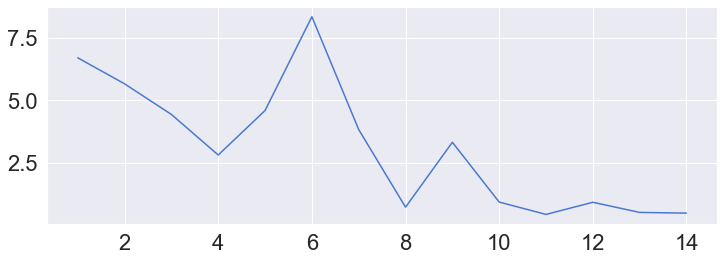

In [ ]:
# Performance plot by sequence length
seq_test = pd.DataFrame()
for key, val in Score.items():
    seq_test = pd.concat([seq_test, val.iloc[1,:].T], axis=1)

seq_test = seq_test.T
seq_test.index = seqsize_list
seq_test['MSE'].plot(figsize=(12,4))
plt.show()

#### Optimal Batchsize

In [ ]:
# Data Loading
location = './Economy.csv'
raw_all = pd.read_csv(location)
raw_all = raw_all[(raw_all['Region'] == 50000) & (raw_all['Building_Type'] == 0)]
raw_all

# Feature Engineering
raw_all['Date'] = pd.to_datetime(raw_all['Date'])
raw_all.index = raw_all['Date']
raw_all = raw_all[raw_all.index >= '2010-01-01']
raw_all = raw_all[raw_all.index <= '2017-12-31']
raw_all.fillna(method='bfill', inplace=True)

# Data Split
Y_colname = ['Price']
X_remove = ['Date', 'Region', 'Price_Sido', 'Building_Type']
X_colname = [x for x in raw_all.columns if x not in Y_colname+X_remove]
X_train, X_test, Y_train, Y_test = datasplit_ts(raw_all, Y_colname, X_colname, '2016-01-01')

# Parameters
scaler_X_tr = preprocessing.MinMaxScaler()
scaler_Y_tr = preprocessing.MinMaxScaler()
sequence = 10
batch_size = 32
epoch = 20
verbose = 0
dropout_ratio = 0

# Feature Engineering
## Scaling
X_train_scaled = scaler_X_tr.fit_transform(X_train)
Y_train_scaled = scaler_Y_tr.fit_transform(Y_train)
X_test_scaled = scaler_X_tr.transform(X_test)
Y_test_scaled = scaler_Y_tr.transform(Y_test)

####################### iterations #######################
Score = dict()
batchsize_list = [i for i in range(5, 50, 5)]
for i in tqdm(batchsize_list):
    batch_size = i

    ## X / Y Split
    X_train, Y_train = [], []
    for index in range(len(X_train_scaled) - sequence):
        X_train.append(np.array(X_train_scaled[index: index + sequence]))
        Y_train.append(np.ravel(Y_train_scaled[index + sequence:index + sequence + 1]))
    X_train, Y_train = np.array(X_train), np.array(Y_train)
    X_test, Y_test = [], []
    for index in range(len(X_test_scaled) - sequence):
        X_test.append(np.array(X_test_scaled[index: index + sequence]))
        Y_test.append(np.ravel(Y_test_scaled[index + sequence:index + sequence + 1]))  
    X_test, Y_test = np.array(X_test), np.array(Y_test) 

    ## Retype and Reshape
    X_train = X_train.reshape(X_train.shape[0], sequence, -1)
    X_test = X_test.reshape(X_test.shape[0], sequence, -1)
    print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
    print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

    # GRU
    model = Sequential()
    model.add(GRU(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
    model.add(Dropout(dropout_ratio)) 
    model.add(GRU(256, return_sequences=True, activation="relu"))
    model.add(Dropout(dropout_ratio)) 
    model.add(GRU(128, return_sequences=True, activation="relu"))
    model.add(Dropout(dropout_ratio)) 
    model.add(GRU(64, return_sequences=False, activation="relu"))
    model.add(Dropout(dropout_ratio)) 
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    # model.summary()
    model_fit = model.fit(X_train, Y_train, 
                          batch_size=batch_size, epochs=epoch,
                          verbose=verbose)

    # plt.plot(pd.DataFrame(model_fit.history))
    # plt.grid(True)
    # plt.show()

    # prediction
    Y_train_pred = model.predict(X_train)
    Y_test_pred = model.predict(X_test)

    # evaluation
    result = model.evaluate(X_test, Y_test_pred)
    if scaler_Y_tr != []:
        Y_train = scaler_Y_tr.inverse_transform(Y_train)
        Y_train_pred = scaler_Y_tr.inverse_transform(Y_train_pred)
        Y_test = scaler_Y_tr.inverse_transform(Y_test)
        Y_test_pred = scaler_Y_tr.inverse_transform(Y_test_pred)
    Score_GRU, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), 
                                                          pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=False)
#     display(Score_GRU)
    Score[str(batch_size)] = Score_GRU

    # error analysis
    # error_analysis(Residual_te, ['Error'], X_test_feR.reset_index().iloc[:,1:].loc[Residual_te.index], graph_on=True)

  0%|                                                                                            | 0/9 [00:00<?, ?it/s]

Train_size: (72, 18) Test_size: (24, 18)
X_train: (72, 13) Y_train: (72, 1)
X_test: (24, 13) Y_test: (24, 1)
X_train: (62, 10, 13) Y_train: (62, 1)
X_test: (14, 10, 13) Y_test: (14, 1)
1/1 [==============================] - 0s 998us/step - loss: 9.1355e-15


 11%|█████████▎                                                                          | 1/9 [00:08<01:08,  8.57s/it]

X_train: (62, 10, 13) Y_train: (62, 1)
X_test: (14, 10, 13) Y_test: (14, 1)
1/1 [==============================] - 0s 997us/step - loss: 6.0904e-15


 22%|██████████████████▋                                                                 | 2/9 [00:15<00:57,  8.19s/it]

X_train: (62, 10, 13) Y_train: (62, 1)
X_test: (14, 10, 13) Y_test: (14, 1)
1/1 [==============================] - 0s 998us/step - loss: 3.0452e-15


 33%|████████████████████████████                                                        | 3/9 [00:22<00:46,  7.82s/it]

X_train: (62, 10, 13) Y_train: (62, 1)
X_test: (14, 10, 13) Y_test: (14, 1)
1/1 [==============================] - 0s 997us/step - loss: 4.0602e-15


 44%|█████████████████████████████████████▎                                              | 4/9 [00:29<00:37,  7.49s/it]

X_train: (62, 10, 13) Y_train: (62, 1)
X_test: (14, 10, 13) Y_test: (14, 1)
1/1 [==============================] - 0s 0s/step - loss: 9.1355e-15


 56%|██████████████████████████████████████████████▋                                     | 5/9 [00:35<00:28,  7.03s/it]

X_train: (62, 10, 13) Y_train: (62, 1)
X_test: (14, 10, 13) Y_test: (14, 1)
1/1 [==============================] - 0s 998us/step - loss: 3.5527e-15


 67%|████████████████████████████████████████████████████████                            | 6/9 [00:41<00:20,  6.86s/it]

X_train: (62, 10, 13) Y_train: (62, 1)
X_test: (14, 10, 13) Y_test: (14, 1)
1/1 [==============================] - 0s 2ms/step - loss: 4.0602e-15


 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [00:48<00:13,  6.66s/it]

X_train: (62, 10, 13) Y_train: (62, 1)
X_test: (14, 10, 13) Y_test: (14, 1)
1/1 [==============================] - 0s 997us/step - loss: 4.0602e-15


 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [00:54<00:06,  6.53s/it]

X_train: (62, 10, 13) Y_train: (62, 1)
X_test: (14, 10, 13) Y_test: (14, 1)
1/1 [==============================] - 0s 997us/step - loss: 2.0301e-15


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:00<00:00,  6.67s/it]


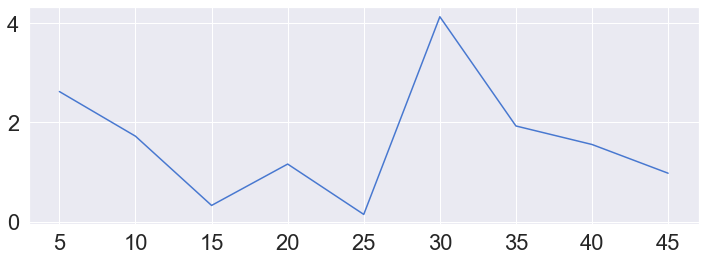

In [ ]:
# Performance plot by sequence length
seq_test = pd.DataFrame()
for key, val in Score.items():
    seq_test = pd.concat([seq_test, val.iloc[1,:].T], axis=1)

seq_test = seq_test.T
seq_test.index = batchsize_list
seq_test['MSE'].plot(figsize=(12,4))
plt.show()

#### Final

Train_size: (72, 18) Test_size: (24, 18)
X_train: (72, 13) Y_train: (72, 1)
X_test: (24, 13) Y_test: (24, 1)
X_train: (62, 10, 13) Y_train: (62, 1)
X_test: (14, 10, 13) Y_test: (14, 1)
Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_206 (GRU)                (None, 10, 128)           54912     
_________________________________________________________________
dropout_240 (Dropout)        (None, 10, 128)           0         
_________________________________________________________________
gru_207 (GRU)                (None, 10, 256)           296448    
_________________________________________________________________
dropout_241 (Dropout)        (None, 10, 256)           0         
_________________________________________________________________
gru_208 (GRU)                (None, 10, 128)           148224    
_________________________________________________________________


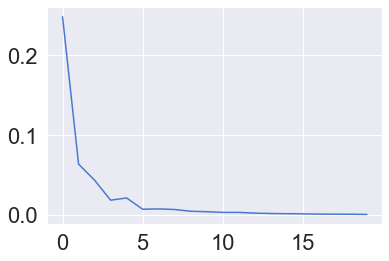

1/1 [==============================] - 0s 998us/step - loss: 4.0602e-15


MAE  MSE  MAPE
Train 0.38 0.27  0.43
Test  0.57 0.38  0.58

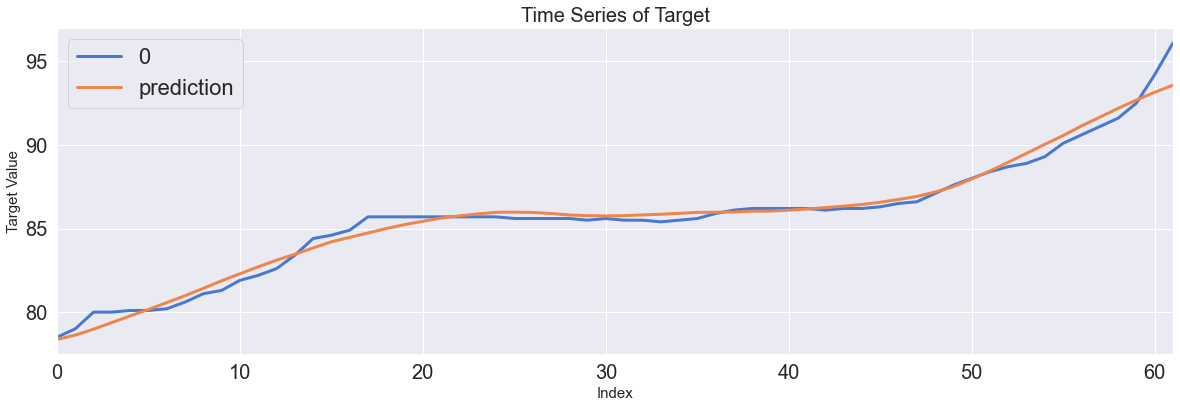

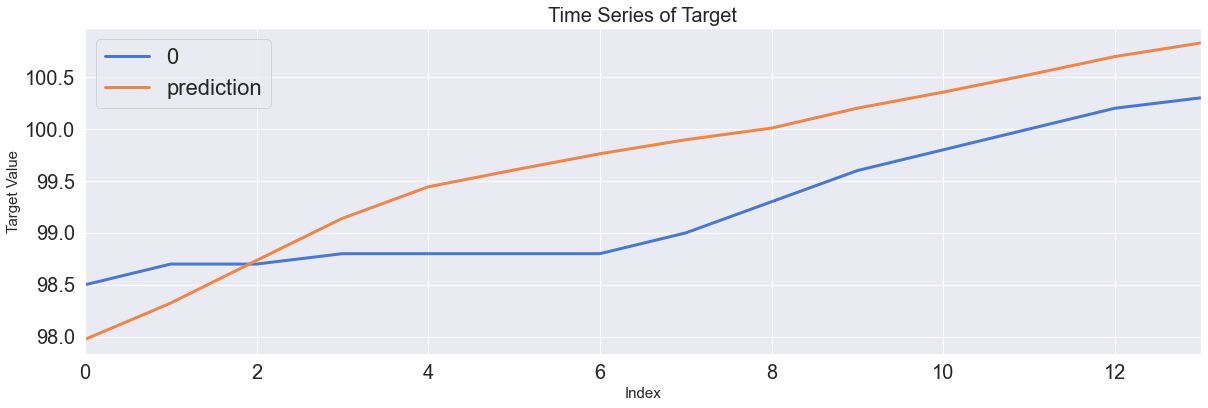

In [ ]:
# Data Loading
location = './Economy.csv'
raw_all = pd.read_csv(location)
raw_all = raw_all[(raw_all['Region'] == 50000) & (raw_all['Building_Type'] == 0)]
raw_all

# Feature Engineering
raw_all['Date'] = pd.to_datetime(raw_all['Date'])
raw_all.index = raw_all['Date']
raw_all = raw_all[raw_all.index >= '2010-01-01']
raw_all = raw_all[raw_all.index <= '2017-12-31']
raw_all.fillna(method='bfill', inplace=True)

# Data Split
Y_colname = ['Price']
X_remove = ['Date', 'Region', 'Price_Sido', 'Building_Type']
X_colname = [x for x in raw_all.columns if x not in Y_colname+X_remove]
X_train, X_test, Y_train, Y_test = datasplit_ts(raw_all, Y_colname, X_colname, '2016-01-01')

# Parameters
scaler_X_tr = preprocessing.MinMaxScaler()
scaler_Y_tr = preprocessing.MinMaxScaler()
sequence = 10
batch_size = 20
epoch = 20
verbose = 1
dropout_ratio = 0

# Feature Engineering
## Scaling
X_train_scaled = scaler_X_tr.fit_transform(X_train)
Y_train_scaled = scaler_Y_tr.fit_transform(Y_train)
X_test_scaled = scaler_X_tr.transform(X_test)
Y_test_scaled = scaler_Y_tr.transform(Y_test)

## X / Y Split
X_train, Y_train = [], []
for index in range(len(X_train_scaled) - sequence):
    X_train.append(np.array(X_train_scaled[index: index + sequence]))
    Y_train.append(np.ravel(Y_train_scaled[index + sequence:index + sequence + 1]))
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_test, Y_test = [], []
for index in range(len(X_test_scaled) - sequence):
    X_test.append(np.array(X_test_scaled[index: index + sequence]))
    Y_test.append(np.ravel(Y_test_scaled[index + sequence:index + sequence + 1]))  
X_test, Y_test = np.array(X_test), np.array(Y_test) 

## Retype and Reshape
X_train = X_train.reshape(X_train.shape[0], sequence, -1)
X_test = X_test.reshape(X_test.shape[0], sequence, -1)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# GRU
model = Sequential()
model.add(GRU(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
model.add(Dropout(dropout_ratio)) 
model.add(GRU(256, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(GRU(128, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(GRU(64, return_sequences=False, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
model_fit = model.fit(X_train, Y_train, 
                      batch_size=batch_size, epochs=epoch,
                      verbose=verbose)

plt.plot(pd.DataFrame(model_fit.history))
plt.grid(True)
plt.show()

# prediction
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

# evaluation
result = model.evaluate(X_test, Y_test_pred)
if scaler_Y_tr != []:
    Y_train = scaler_Y_tr.inverse_transform(Y_train)
    Y_train_pred = scaler_Y_tr.inverse_transform(Y_train_pred)
    Y_test = scaler_Y_tr.inverse_transform(Y_test)
    Y_test_pred = scaler_Y_tr.inverse_transform(Y_test_pred)
Score_GRU, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), 
                                                      pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=True)
display(Score_GRU)

# error analysis
# error_analysis(Residual_te, ['Error'], X_test_feR.reset_index().iloc[:,1:].loc[Residual_te.index], graph_on=True)